In [ ]:
############################################
# 1. IMPORT LIBRARIES & MOUNT (if needed)
############################################

import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 100

We begin by importing the essential libraries used throughout the project:

pandas and numpy for data manipulation and numerical operations.
random for picking random values or random choices if needed.
seaborn and matplotlib for data visualization.


In [ ]:
############################################
# 2. LOAD DATASET
############################################

missing_values = [
    "Not Available", "N/A", "na", "NaN", "nan",
    "NULL", "Unknown", "--", "not available",
    "unknown", "null", ""
]

df = pd.read_csv("content/Final_corrupted_dataset.csv", na_values=missing_values)

print("Initial dataset shape:", df.shape)
# df.head(10)


We define a list of missing_values placeholders, such as "Not Available", "N/A", and "". This ensures that when pandas reads the CSV, any cell matching these strings becomes a NaN (missing value).
We specify the file_path to our CSV.
pd.read_csv loads the data into a DataFrame df. The parameter na_values=missing_values tells pandas to treat those strings as missing.
We then print the initial shape of the DataFrame to see how many rows/columns we have, and df.head(10) shows the first 10 rows so we can quickly inspect what the raw data looks like.

In [ ]:
############################################
# 3. REMOVE DUPLICATES
############################################

df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
print("After removing duplicates, shape =", df.shape)


drop_duplicates scans the DataFrame for any exact duplicate rows and removes them. This prevents counting the same record multiple times.
reset_index(drop=True) reassigns a new integer index from 0 to len(df)-1.
We print the new shape to confirm how many rows remain after duplicates are removed. This helps keep the data unique and consistent.

In [ ]:
############################################
# 4. QUICK INSPECTION
############################################

print("\n--- INFO ---")
df.info()

print("\n--- DESCRIBE (include='all') ---")
display(df.describe(include='all'))

print("\n--- SAMPLE ROWS ---")
display(df.sample(5))


df.info(): Summarizes each column’s data type, the number of non-null values, and the overall memory usage. This helps identify columns with missing data or incorrect data types.
df.describe(include='all'): Gives a statistical summary for all columns—both numeric (mean, std, min, max) and categorical (count, unique, top, freq).
df.sample(5): Displays 5 random rows so we can see the variety of entries. This can reveal unexpected placeholders or anomalies that might not appear in the first few rows.

In [13]:
############################################
# 5. CONVERT WRITTEN-OUT NUMBERS TO DIGITS
############################################

word_to_number_dict = {
    "zero": 0, "one": 1, "two": 2, "three": 3, "four": 4,
    "five": 5, "six": 6, "seven": 7, "eight": 8, "nine": 9,
    "ten": 10, "eleven": 11, "twelve": 12, "thirteen": 13,
    "fourteen": 14, "fifteen": 15, "sixteen": 16,
    "seventeen": 17, "eighteen": 18, "nineteen": 19
}
tens_dict = {
    "twenty": 20, "thirty": 30, "forty": 40, "fifty": 50,
    "sixty": 60, "seventy": 70, "eighty": 80, "ninety": 90
}

def words_to_numbers(value):
    """Convert English words (like 'sixty-five') to an integer if possible."""
    if not isinstance(value, str):
        return value  # If it's already numeric or NaN, return as-is

    word = value.strip().lower()
    # Direct 0-19
    if word in word_to_number_dict:
        return word_to_number_dict[word]
    # Direct tens (20,30,...90)
    if word in tens_dict:
        return tens_dict[word]
    # Compound numbers "twenty-three", "ninety-nine", etc.
    if "-" in word:
        parts = word.split("-")
        if len(parts) == 2:
            part1, part2 = parts
            if part1 in tens_dict and part2 in word_to_number_dict:
                return tens_dict[part1] + word_to_number_dict[part2]
    # Not recognized => return original
    return value

# Define numeric columns that might have textual numbers
possible_text_nums = [
    "Hours_Studied", "Sleep_Hours", "Previous_Scores",
    "Tutoring_Sessions", "Physical_Activity", "Exam_Score"
]

# Converting
for col in possible_text_nums:
    if col in df.columns:
        df[col] = df[col].apply(words_to_numbers)


Some numeric columns may contain textual representations (e.g., "sixty-five") that should be actual numbers (65).
words_to_numbers tries to convert words like "twenty-three" into the correct integer. If it can’t, it returns the original value.
We apply this function only to columns we suspect might have textual numeric data (like Hours_Studied, Sleep_Hours, etc.).
This step ensures we don’t have strings like "eight" in numeric columns.

In [15]:
############################################
# 6. FORCE NUMERIC COLUMNS
############################################

# We expect these columns to be numeric
numeric_cols = [
    "Hours_Studied", "Attendance", "Sleep_Hours",
    "Previous_Scores", "Tutoring_Sessions",
    "Physical_Activity", "Exam_Score"  # If it exists
]

for col in numeric_cols:
    if col in df.columns:
        # Convert to numeric, coerce to NaN if unconvertible
        df[col] = pd.to_numeric(df[col], errors='coerce')


We define numeric_cols as columns that we want to be numeric.
pd.to_numeric with errors='coerce' attempts to convert each entry to a float. If it can’t (e.g., leftover text), it becomes NaN.
This step is critical if the dataset has inconsistent types. By the end, these columns are guaranteed to be numeric or missing.

In [17]:
############################################
# 7. FIX INCONSISTENT STRINGS (e.g. 'low' -> 'Low')
############################################

df.replace({"low": "Low", "high": "High", "medium": "Medium"}, inplace=True)

# Also unify 'Male'/'Female' if needed
# More robust approach below with mapping


If we see columns containing strings like "low", "Low", or "LOW", we unify them to a standard.
This line specifically addresses “low/high/medium” cases, ensuring consistent capitalization.
We might have already handled them in a later step, but doing it here can help if any columns remain as strings.

In [19]:
############################################
# 8. HANDLE MISSING VALUES
############################################

# (A) Numeric columns => fill with median
for col in numeric_cols:
    if col in df.columns:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

# (B) Categorical columns => fill with mode
# Define some likely categorical columns
cat_cols = [
    "Parental_Involvement", "Access_to_Resources", "Extracurricular_Activities",
    "Motivation_Level", "Internet_Access", "Family_Income", "Teacher_Quality", "School_Type", "Peer_Influence", "Learning_Disabilities", "Parental_Education_Level", "Distance_from_Home",
    "Gender"
]

In [21]:
# Define categorical replacements
categorical_replacements = {
    "Parental_Involvement": ["Low", "Medium", "High"],
    "Access_to_Resources": ["Low", "Medium", "High"],
    "Extracurricular_Activities": ["Yes", "No"],
    "Motivation_Level": ["Low", "Medium", "High"],
    "Internet_Access": ["Yes"],
    "Family_Income": ["Low", "Medium"],
    "Teacher_Quality": ["Low", "Medium", "High"],
    "School_Type": ["Public"],
    "Peer_Influence": ["Positive", "Neutral", "Negative"],
    "Learning_Disabilities": ["No"],
    "Parental_Education_Level": ["High School", "College", "Post Graduate"],
    "Distance_from_Home": ["Near", "Moderate"],
    "Gender": ["Male", "Female"]
}

# Fill missing categorical values randomly
for col, choices in categorical_replacements.items():
    if col in df.columns:
        df[col].fillna(random.choice(choices), inplace=True)

For numeric columns, we compute the median and fill any NaN with that median. This is robust to outliers and ensures no numeric column remains missing.
For categorical columns, we pick the mode (most frequent category) and fill missing values with that. This is a simple approach that ensures each category remains consistent.
Family_Income: If we discovered that the entire column was missing, we fill it with a default numeric value (e.g., 2.0, signifying “Medium”). If only partial data is missing, we fill with the median.

In [25]:
############################################
# 9. NORMALIZE CATEGORICAL STRINGS
############################################

def normalize_strings(series, valid_values):
    """ Convert series to lowercase, strip spaces, map to valid_values if found. """
    series = series.astype(str).str.strip().str.lower()
    mapping = {v.lower(): v for v in valid_values}
    return series.map(mapping).fillna(series)  # if not found, keep original

# For "Low"/"Medium"/"High" columns:
lmh_cols = ["Parental_Involvement", "Access_to_Resources", "Motivation_Level", "Teacher_Quality", "Family_Income"]
for col in lmh_cols:
    if col in df.columns:
        df[col] = normalize_strings(df[col], ["Low", "Medium", "High"])

# For yes/no columns:
yn_cols = ["Internet_Access", "Extracurricular_Activities", "Learning_Disabilities"]
for col in yn_cols:
    if col in df.columns:
        df[col] = normalize_strings(df[col], ["Yes", "No"])

# For "School_Type" => "Public"/"Private"
if "School_Type" in df.columns:
    df["School_Type"] = normalize_strings(df["School_Type"], ["Public", "Private"])

# For "Peer_Influence" => "Positive"/"Neutral"/"Negative"
if "Peer_Influence" in df.columns:
    df["Peer_Influence"] = normalize_strings(df["Peer_Influence"], ["Positive", "Neutral", "Negative"])

# For "Distance_from_Home" => "Near"/"Moderate"/"Far"
if "Distance_from_Home" in df.columns:
    df["Distance_from_Home"] = normalize_strings(df["Distance_from_Home"], ["Near", "Moderate", "Far"])

# For "Parental_Education_Level" => "High School", "College", "Postgraduate"
if "Parental_Education_Level" in df.columns:
    df["Parental_Education_Level"] = normalize_strings(df["Parental_Education_Level"],["High School", "College", "Post Graduate", "Postgraduate"])

# For "Gender" => "Male"/"Female"
if "Gender" in df.columns:
    df["Gender"] = normalize_strings(df["Gender"], ["Male", "Female"])

#Print all values in unique values in each column
for col in df.columns:
    print(f"\nColumn: {col}")
    print(df[col].unique())


Column: Hours_Studied
[20. 19. 24. 29. 25. 17. 23. 21.  9. 10. 14. 15. 12. 11. 13. 22. 16. 18.
 31.  8. 26.  4. 35. 27. 28. 33. 36. 43. 34.  1. 30.  7. 32. 38.  5.  3.
  2.  6. 39. 37. 44.]

Column: Attendance
[ 84.  64.  98.  89.  92.  88.  78.  94.  80.  97.  82.  68.  60.  70.
  75.  99.  74.  65.  62.  91.  83.  90.  69.  72.  63.  61.  86.  77.
  71.  67.  87.  66.  73.  96. 100.  81.  95.  79.  85.  76.  93.]

Column: Parental_Involvement
['Low' 'Medium' 'High']

Column: Access_to_Resources
['High' 'Medium' 'Low']

Column: Extracurricular_Activities
['No' 'Yes']

Column: Sleep_Hours
[ 7.  8.  6.  9.  5.  4. 10.]

Column: Previous_Scores
[ 73.  59.  91.  98.  65.  75.  68.  50.  80.  71.  88.  97.  72.  74.
  70.  82.  58.  99.  84.  89. 100.  54.  90.  94.  51.  57.  66.  96.
  93.  56.  52.  63.  87.  81.  69.  95.  60.  79.  92.  77.  62.  85.
  64.  76.  55.  86.  61.  53.  83.  78.  67.]

Column: Motivation_Level
['Low' 'Medium' 'High']

Column: Internet_Access
['Yes' 'No']


This function takes a pandas Series and a list of valid_values (e.g., ["Low", "Medium", "High"]).
It converts everything to lowercase, strips whitespace, and tries to match them to the valid set.
If an entry matches, it’s replaced with the correct casing (e.g., “low” → “Low”).
If it doesn’t match, we leave it as-is.
We apply it to columns like Parental_Involvement, Internet_Access, etc. to ensure consistent strings.

In [27]:
############################################
# 10. MAP CATEGORIES TO NUMERIC
############################################

# Apply one-hot encoding
df = pd.get_dummies(df, columns=categorical_replacements.keys(), dtype=int)


For ordinal categories like “Low/Medium/High,” we choose numeric codes (0.33, 0.66, 0.99) to reflect a progression.
For yes/no columns, we use 1.0 and 0.0.
For Gender, we might pick 1.0 for “Male” and 0.0 for “Female.”
This step ensures the final dataset is entirely numeric, which is essential for many ML algorithms.

In [29]:
############################################
# 11. OPTIONAL: CLIP & SCALE NUMERIC
############################################

# Outlier clipping & standardizing 'Hours_Studied'
if "Hours_Studied" in df.columns:
    lb = np.percentile(df["Hours_Studied"], 1)
    ub = np.percentile(df["Hours_Studied"], 99)
    df["Hours_Studied"] = df["Hours_Studied"].clip(lb, ub)

    mean_val = df["Hours_Studied"].mean()
    std_val = df["Hours_Studied"].std()
    df["Hours_Studied"] = (df["Hours_Studied"] - mean_val) / std_val

# Could scale 'Sleep_Hours', 'Physical_Activity', etc.


Outlier clipping: We take the 1st and 99th percentiles of Hours_Studied and clip any values below or above that range. This reduces extreme outliers.
Standardization: We then transform it to have mean=0 and std=1, so Hours_Studied becomes easier for certain ML models to handle.
You can replicate this approach for other columns if you want uniform scaling or outlier handling across the dataset.

In [33]:
############################################
# 12. FINAL CHECK
############################################

print("\n--- FINAL df.info() ---")
df.info()

print("\n--- HEAD ---")
display(df.head(10))

# Confirm no missing values
print("\n--- MISSING VALUES ---")
print(df.isnull().sum())

# Print all values in unique values in each column
for col in df.columns:
    print(f"\nColumn: {col}")
    print(df[col].unique())



--- FINAL df.info() ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 41 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Hours_Studied                          11123 non-null  float64
 1   Attendance                             11123 non-null  float64
 2   Sleep_Hours                            11123 non-null  float64
 3   Previous_Scores                        11123 non-null  float64
 4   Tutoring_Sessions                      11123 non-null  float64
 5   Physical_Activity                      11123 non-null  float64
 6   Exam_Score                             11123 non-null  float64
 7   Parental_Involvement_High              11123 non-null  int32  
 8   Parental_Involvement_Low               11123 non-null  int32  
 9   Parental_Involvement_Medium            11123 non-null  int32  
 10  Access_to_Resources_High               11123 

Hours_Studied  Attendance  Sleep_Hours  Previous_Scores  Tutoring_Sessions  \
0       0.001172        84.0          7.0             73.0                0.0   
1      -0.177399        64.0          7.0             59.0                2.0   
2       0.715457        98.0          7.0             91.0                2.0   
3       1.608313        89.0          8.0             98.0                1.0   
4      -0.177399        92.0          7.0             65.0                3.0   
5      -0.177399        88.0          7.0             75.0                3.0   
6       1.608313        84.0          7.0             68.0                1.0   
7       0.894028        78.0          6.0             50.0                1.0   
8      -0.534542        94.0          6.0             80.0                0.0   
9       0.536886        98.0          7.0             71.0                0.0   

   Physical_Activity  Exam_Score  Parental_Involvement_High  \
0                3.0        67.0                          0   
1                4.0        61.0                          0   
2                4.0        67.0                          0   
3                3.0        71.0                          0   
4                4.0        70.0                          0   
5                3.0        71.0                          0   
6                2.0        67.0                          1   
7                2.0        67.0                          0   
8                1.0        69.0                          0   
9                5.0        72.0                          0   

   Parental_Involvement_Low  Parental_Involvement_Medium  ...  \
0                         1                            0  ...   
1                         1                            0  ...   
2                         0                            1  ...   
3                         1                            0  ...   
4                         0                            1  ...   
5                         0                            1  ...   
6                         0                            0  ...   
7                         1                            0  ...   
8                         0                            1  ...   
9                         0                            1  ...   

   Learning_Disabilities_No  Learning_Disabilities_Yes  \
0                         1                          0   
1                         1                          0   
2                         1                          0   
3                         1                          0   
4                         1                          0   
5                         1                          0   
6                         1                          0   
7                         1                          0   
8                         1                          0   
9                         1                          0   

   Parental_Education_Level_College  Parental_Education_Level_High School  \
0                                 0                                     1   
1                                 1                                     0   
2                                 0                                     0   
3                                 1                                     0   
4                                 1                                     0   
5                                 0                                     0   
6                                 0                                     1   
7                                 0                                     1   
8                                 1                                     0   
9                                 0                                     1   

   Parental_Education_Level_Postgraduate  Distance_from_Home_Far  \
0                                      0                       0   
1                                      0                       0   
2         


--- MISSING VALUES ---
Hours_Studied                            0
Attendance                               0
Sleep_Hours                              0
Previous_Scores                          0
Tutoring_Sessions                        0
Physical_Activity                        0
Exam_Score                               0
Parental_Involvement_High                0
Parental_Involvement_Low                 0
Parental_Involvement_Medium              0
Access_to_Resources_High                 0
Access_to_Resources_Low                  0
Access_to_Resources_Medium               0
Extracurricular_Activities_No            0
Extracurricular_Activities_Yes           0
Motivation_Level_High                    0
Motivation_Level_Low                     0
Motivation_Level_Medium                  0
Internet_Access_No                       0
Internet_Access_Yes                      0
Family_Income_High                       0
Family_Income_Low                        0
Family_Income_Medium          

df.info() once more, to confirm that columns are now the correct type (float64 or int64 for numeric, etc.) and that we have 0 missing values in the columns we’ve handled.
We display the first 10 rows to see if the transformations make sense (e.g., ordinal columns turned to numeric codes, textual columns replaced with numeric or consistent categories).
df.isnull().sum() is a final check that no columns remain with missing data.

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


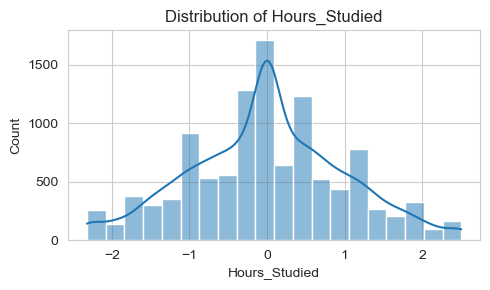

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


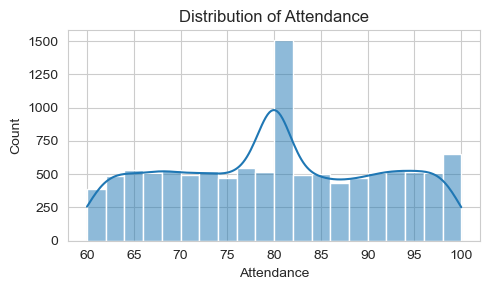

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


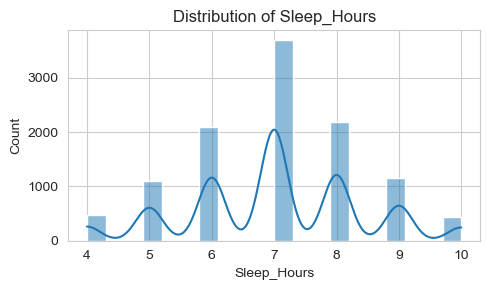

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


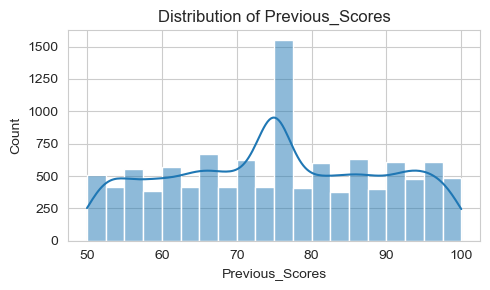

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


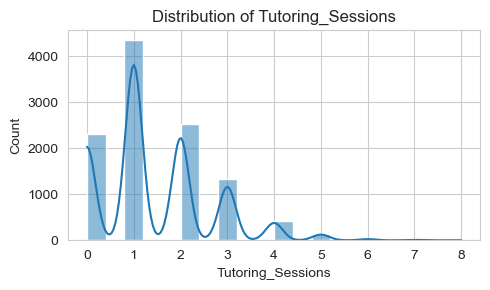

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


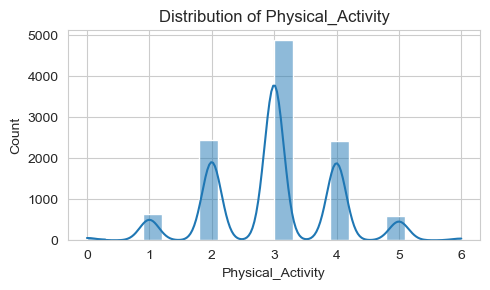

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


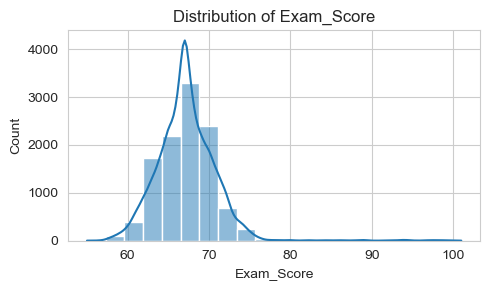

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


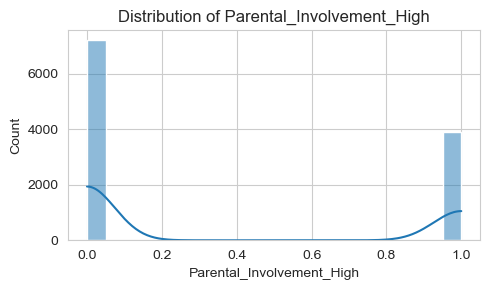

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


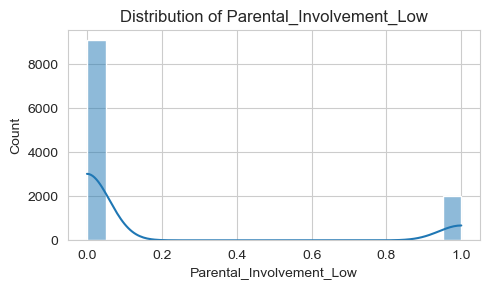

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


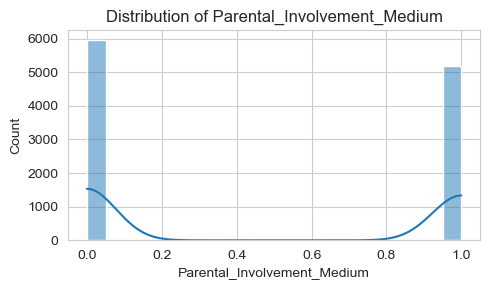

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


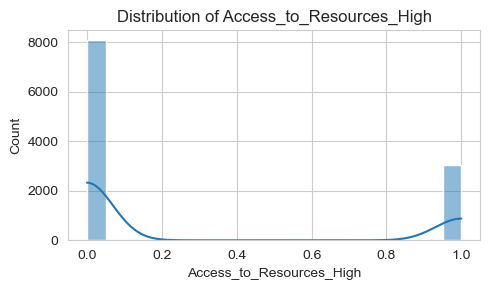

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


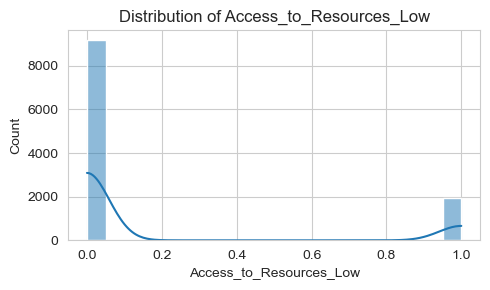

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


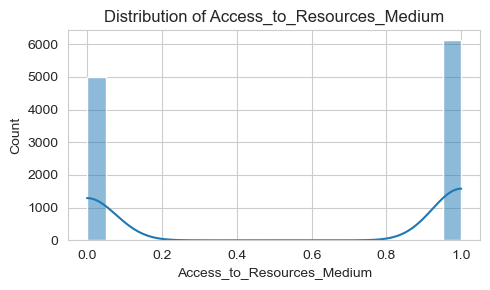

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


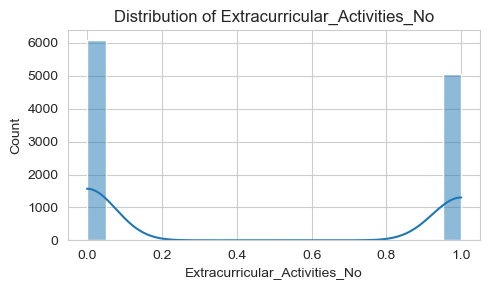

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


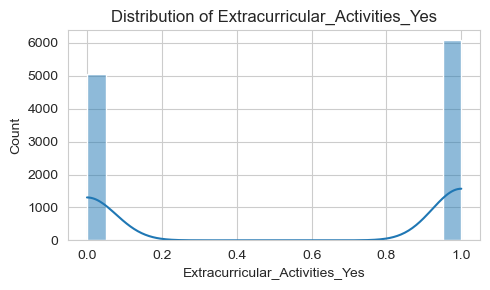

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


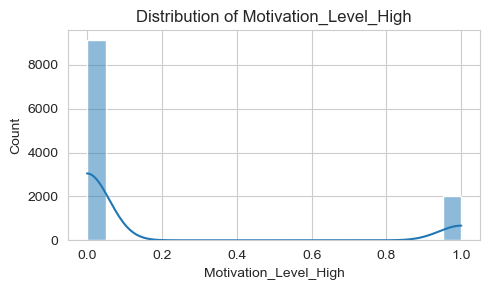

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


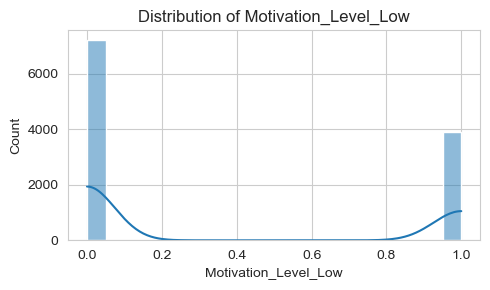

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


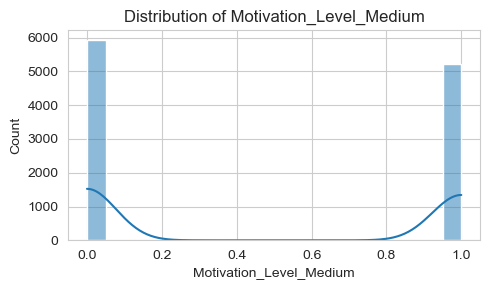

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


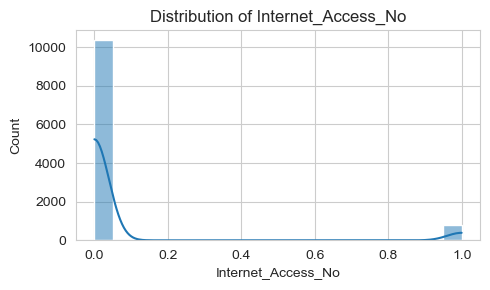

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


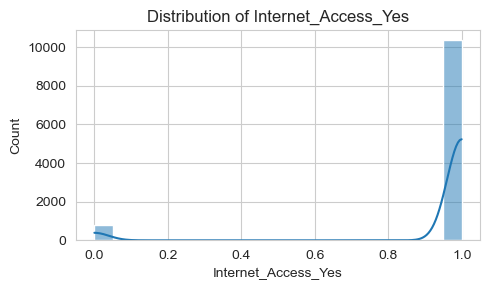

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


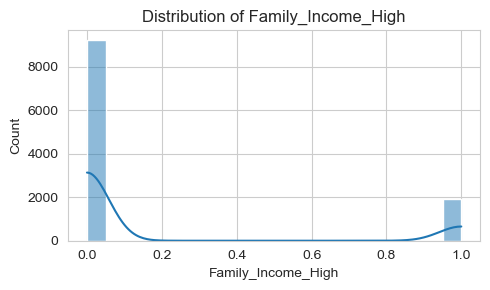

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


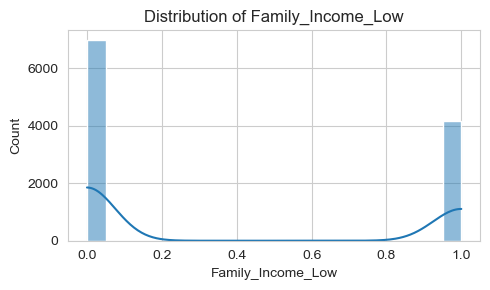

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


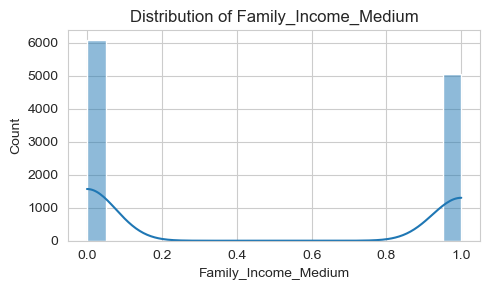

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


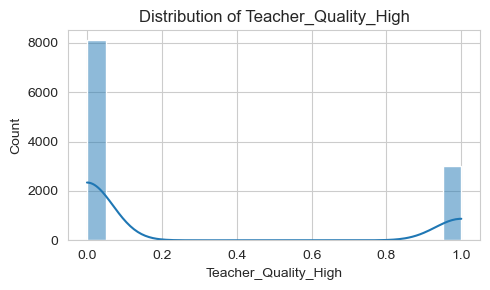

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


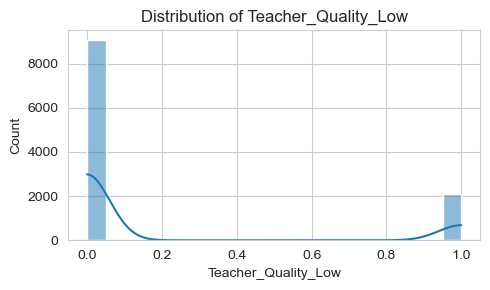

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


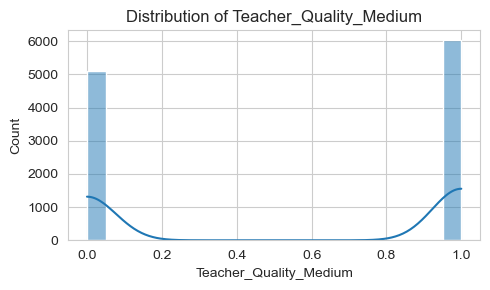

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


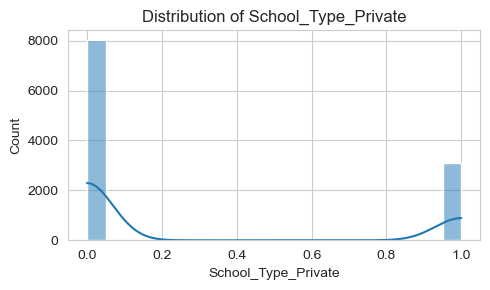

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


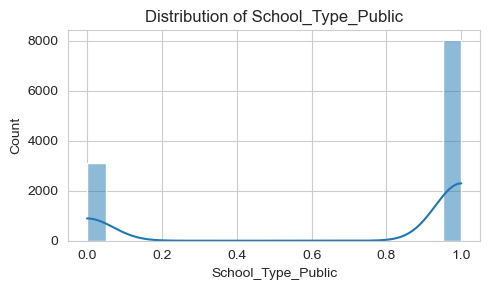

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


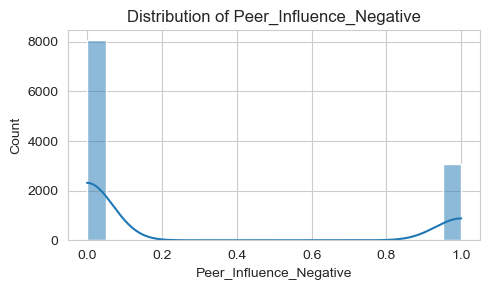

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


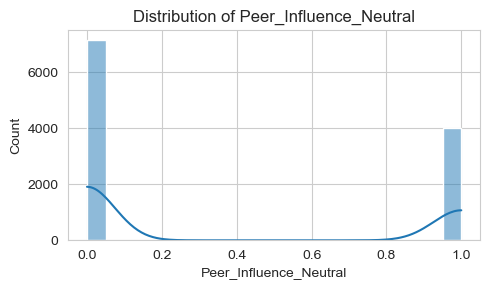

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


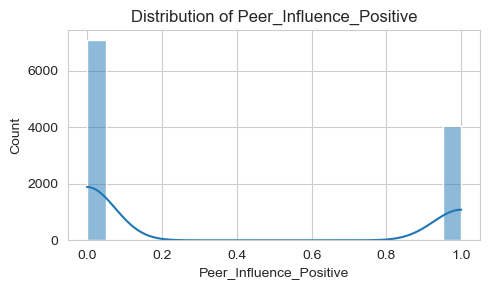

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


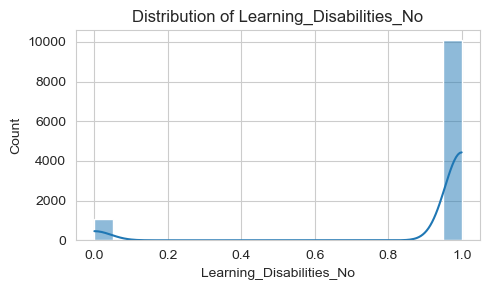

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


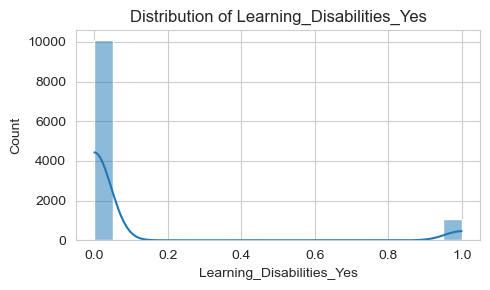

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


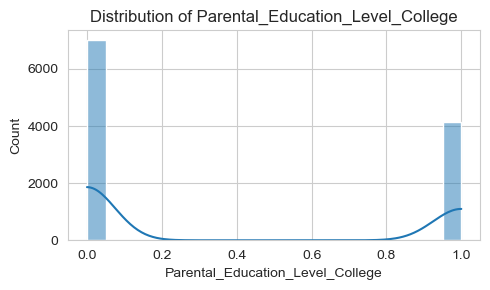

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


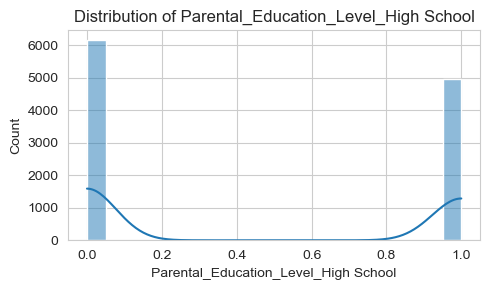

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


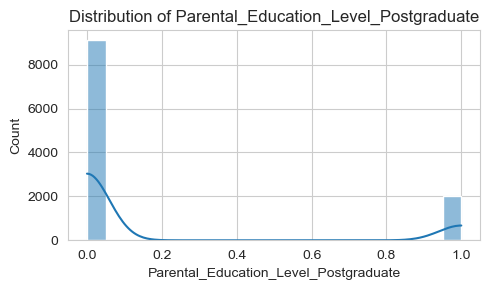

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


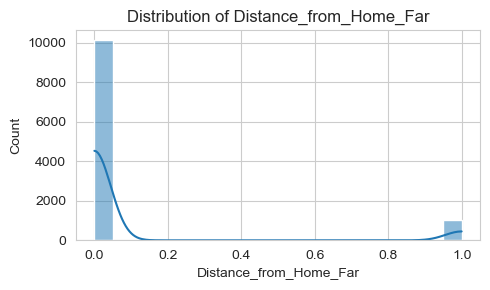

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


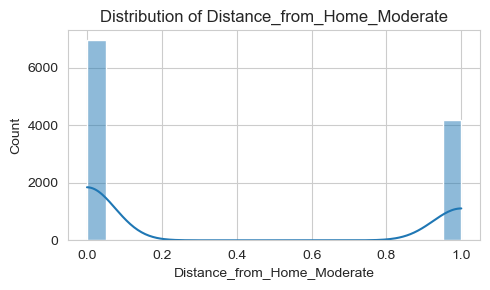

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


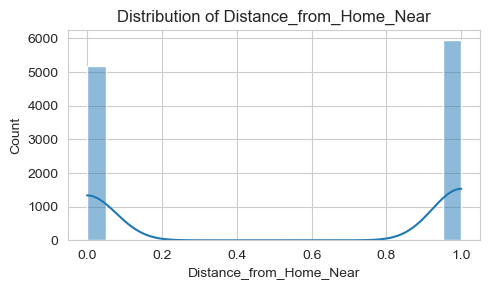

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


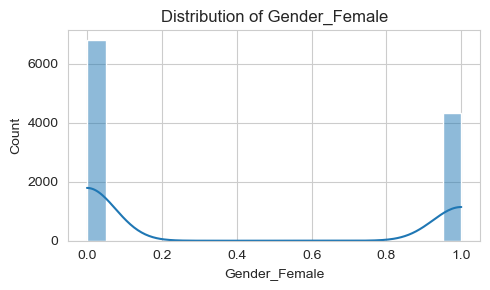

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


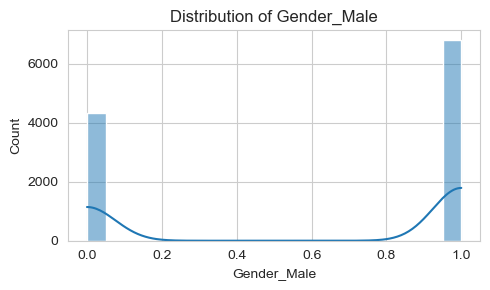

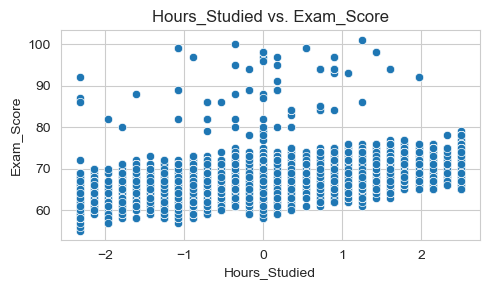

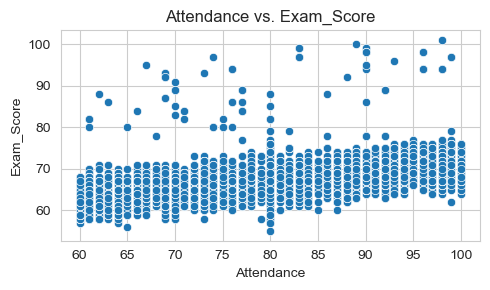

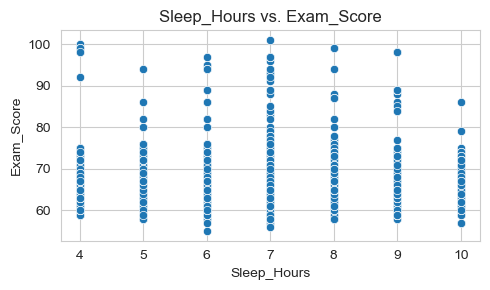

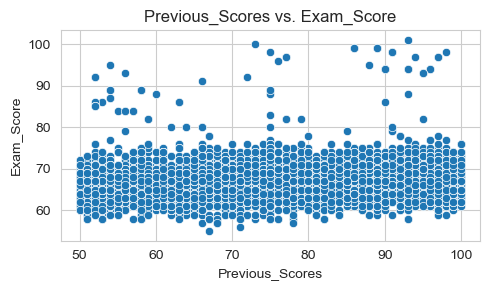

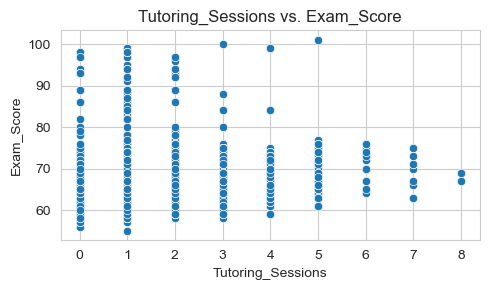

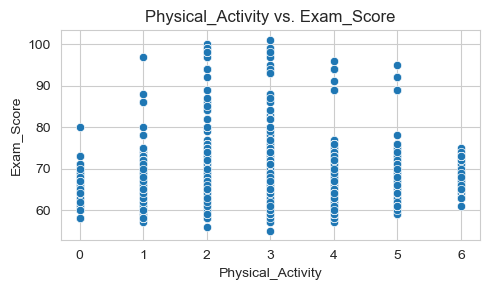

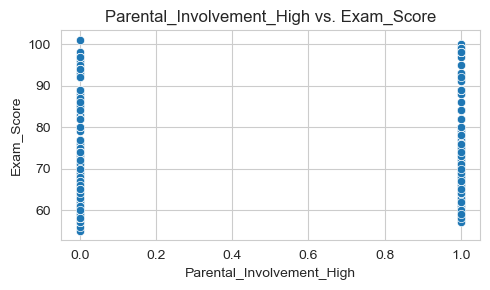

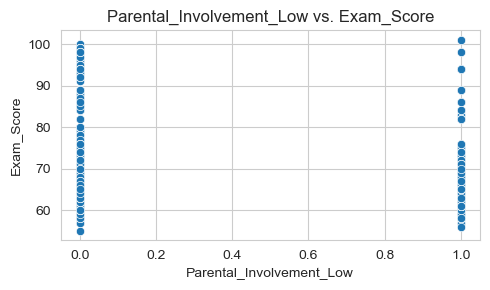

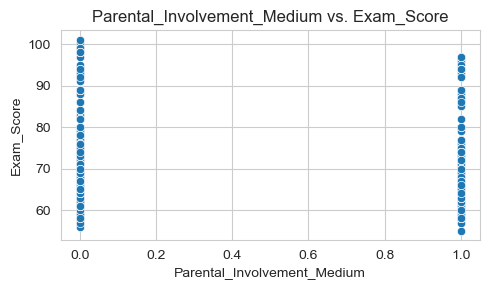

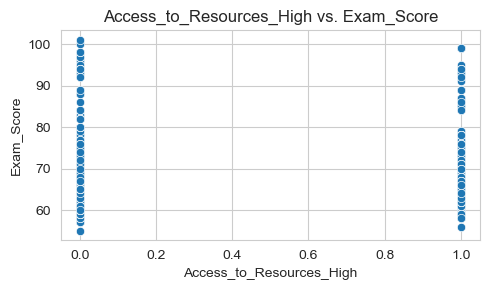

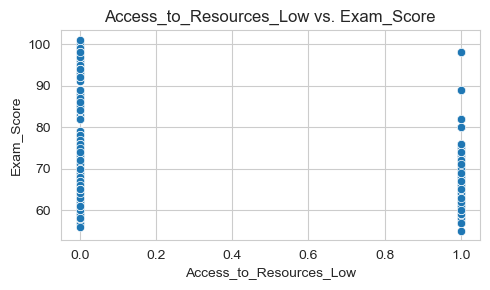

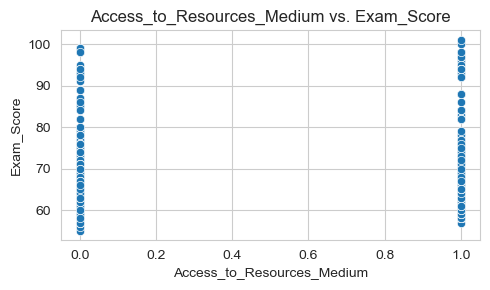

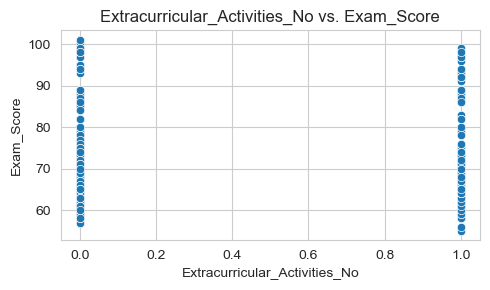

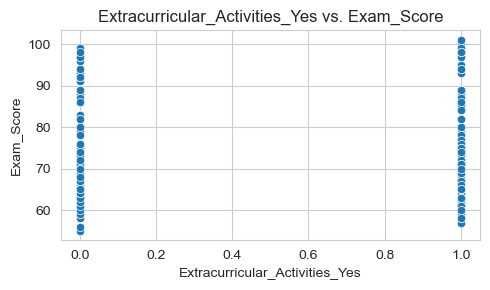

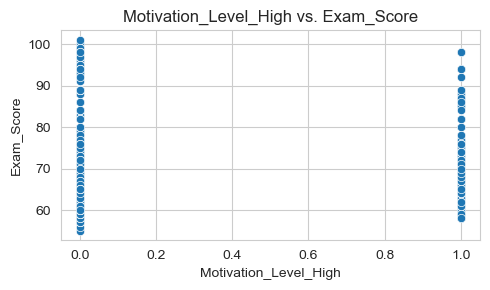

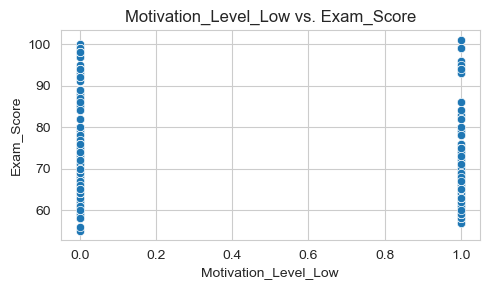

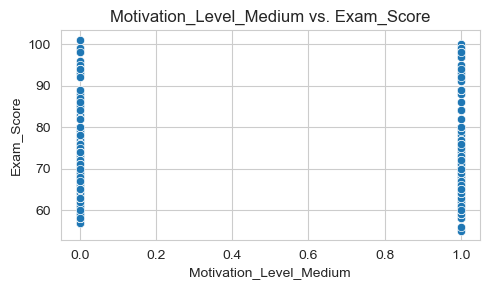

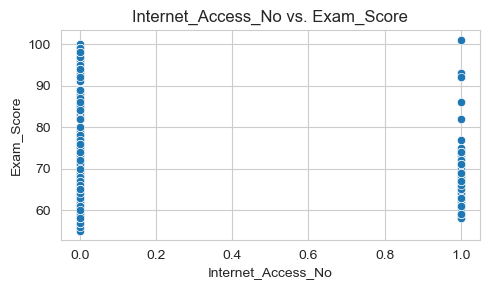

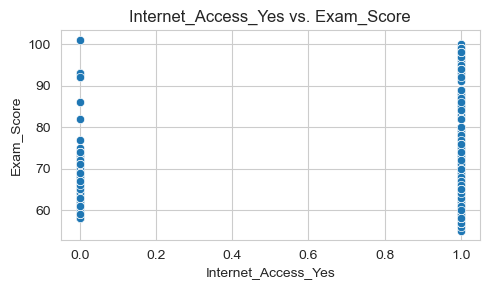

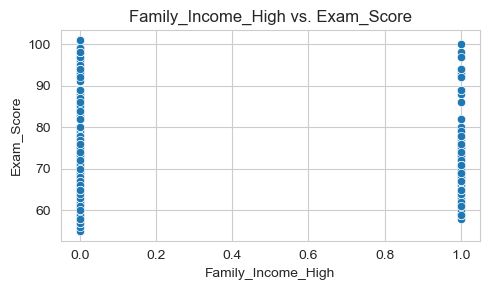

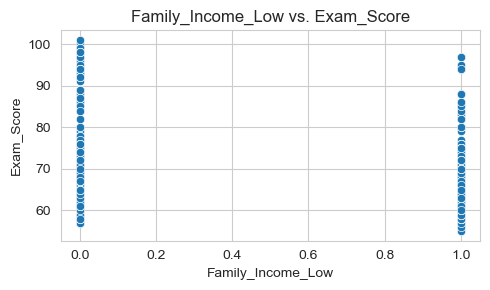

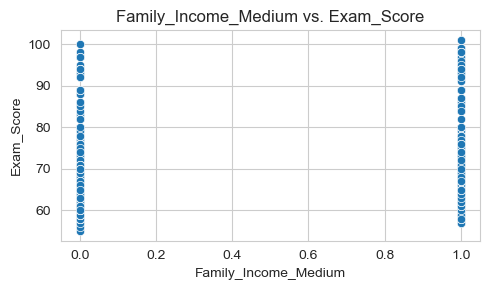

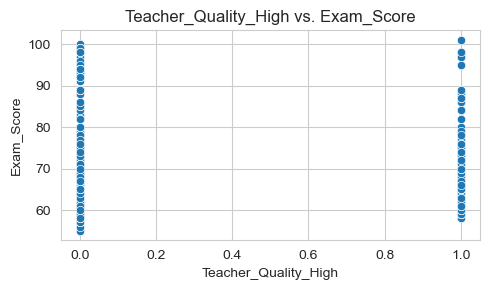

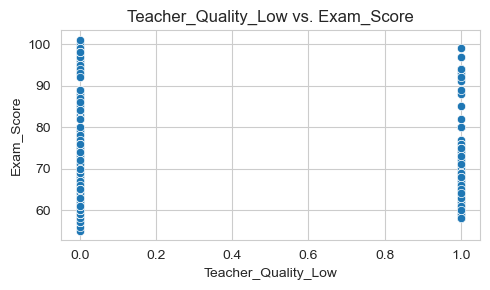

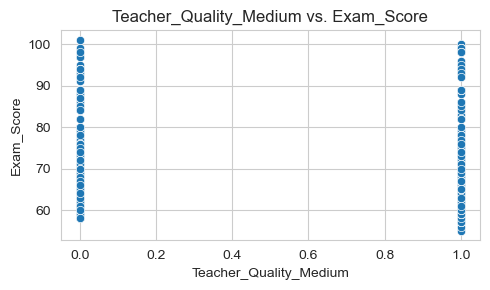

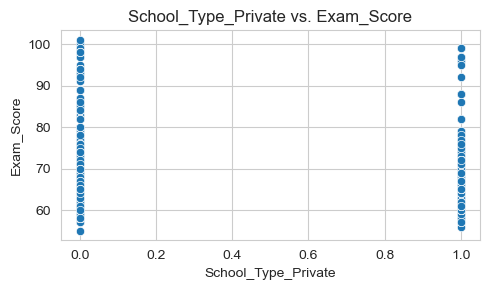

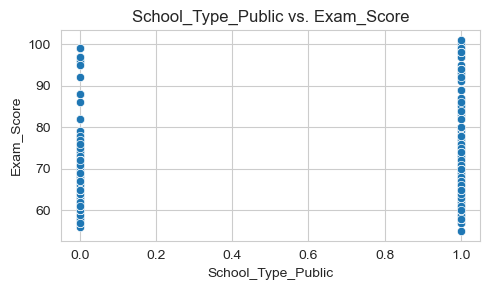

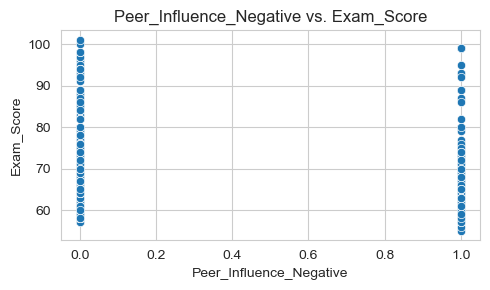

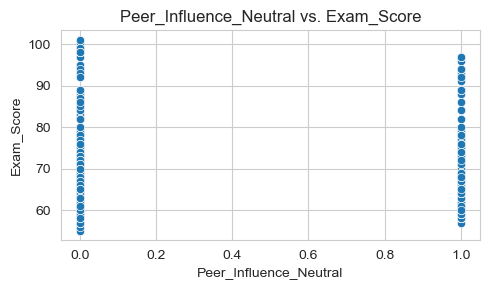

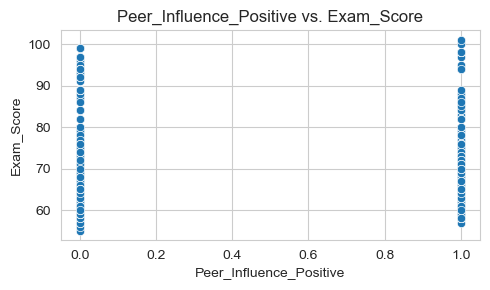

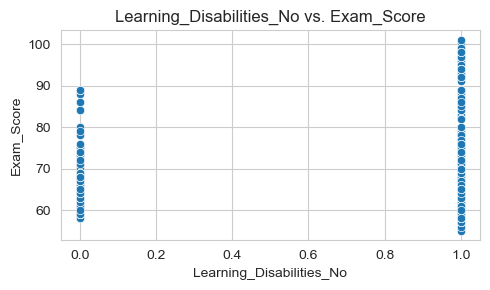

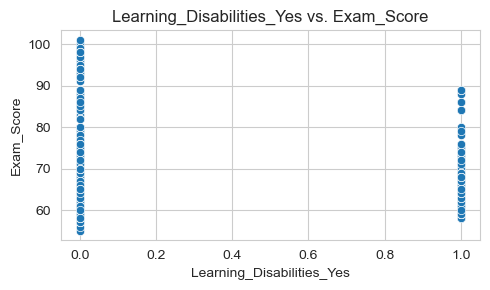

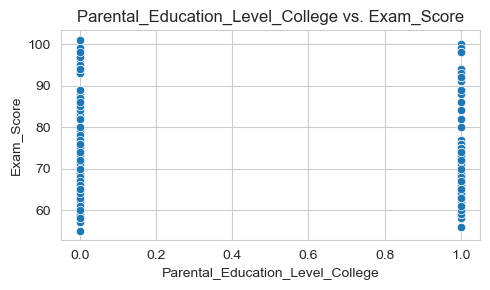

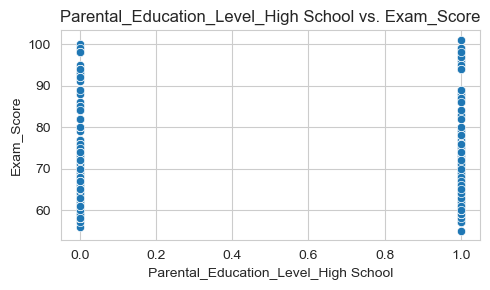

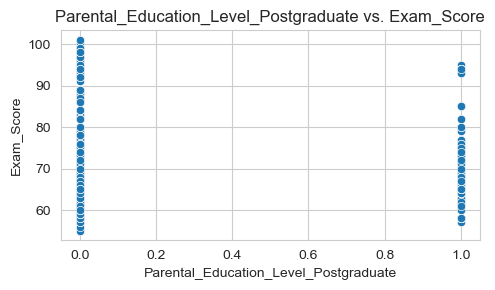

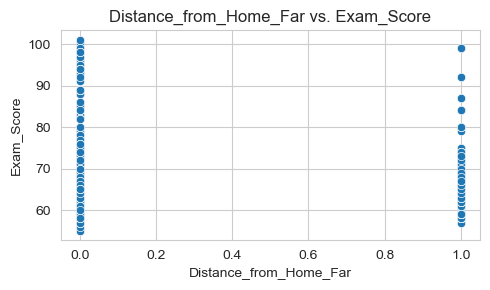

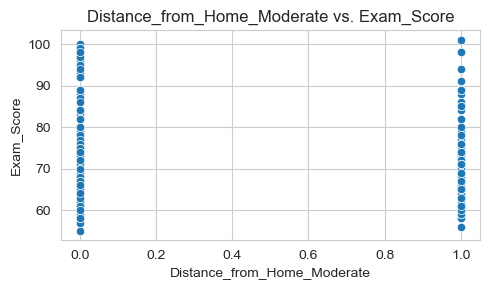

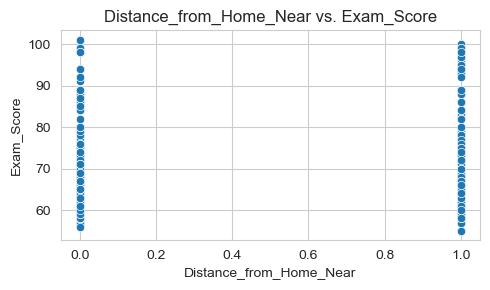

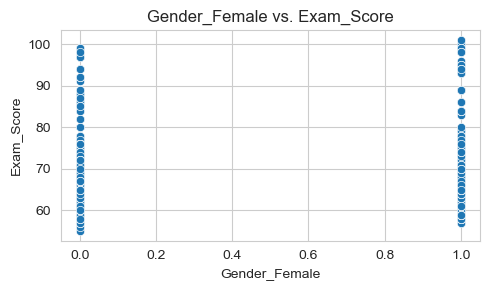

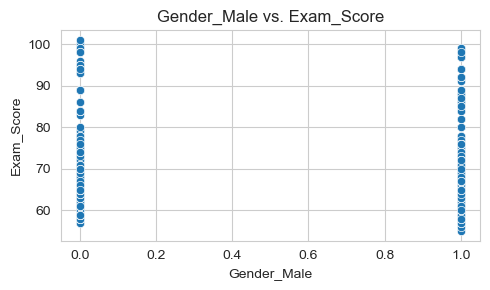

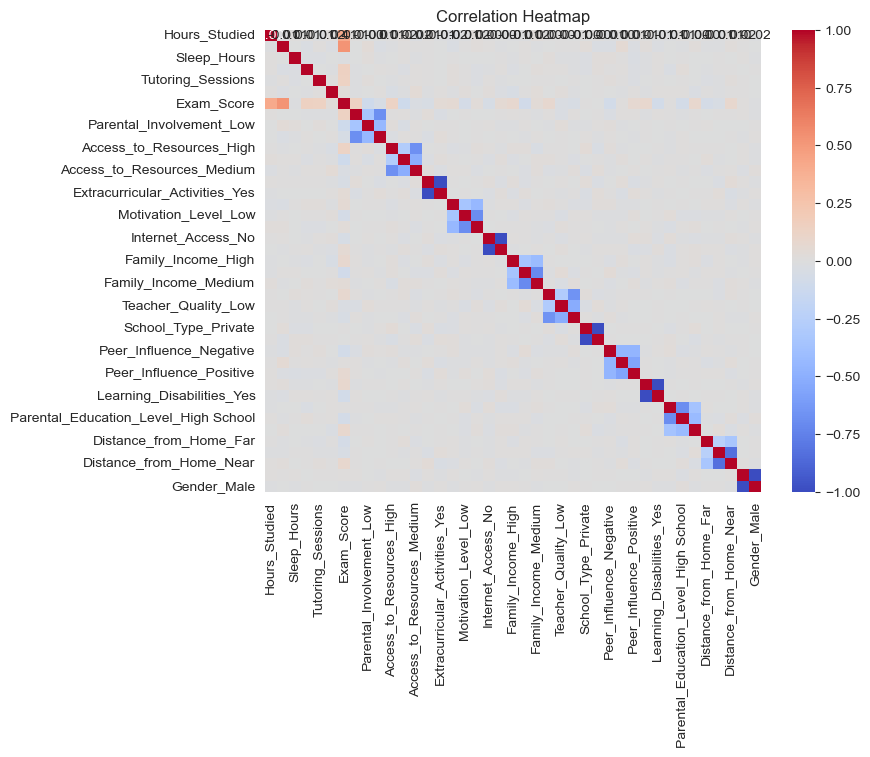

In [35]:
############################################
# 13. EXPLORATORY DATA ANALYSIS
############################################

# (A) Histograms for numeric columns
num_cols_for_plot = df.select_dtypes(include=[np.number]).columns.tolist()

for col in num_cols_for_plot:
    plt.figure(figsize=(5,3))
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

# (B) Countplots for any columns still object dtype
cat_cols_for_plot = df.select_dtypes(include=[object]).columns.tolist()

for col in cat_cols_for_plot:
    plt.figure(figsize=(5,3))
    sns.countplot(x=df[col])
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# (C) Scatter: each numeric vs. 'Exam_Score' (if it exists)
if "Exam_Score" in df.columns:
    for col in num_cols_for_plot:
        if col != "Exam_Score":
            plt.figure(figsize=(5,3))
            sns.scatterplot(x=df[col], y=df["Exam_Score"])
            plt.title(f"{col} vs. Exam_Score")
            plt.tight_layout()
            plt.show()

# (D) Correlation Heatmap
num_data = df.select_dtypes(include=[np.number])
if num_data.shape[1] > 1:
    plt.figure(figsize=(8,6))
    corr = num_data.corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()


Histograms show the distribution (skew, outliers, shape) of each numeric column. We typically look for heavily skewed data or unusual lumps.
Countplots show how frequently each category appears. This can reveal if a category is dominant or if the distribution is balanced.
Scatter plots vs. Exam_Score can highlight whether a numeric feature (e.g., Hours_Studied) correlates with final exam performance. A positive slope might indicate more studying = higher score.
Correlation Heatmap is a quick way to see which numeric features are strongly or weakly correlated. Cells near +1 or -1 indicate a strong positive/negative relationship.

In [43]:
############################################
# 14. SAVE CLEANED DATASET
############################################

df.to_csv("content/Final_cleaned_dataset.csv", index=False)
print("Cleaned dataset saved to 'cleaned_student_performance.csv'")


Cleaned dataset saved to 'cleaned_student_performance.csv'


Finally, we write the fully cleaned and preprocessed DataFrame to a new CSV file, ensuring we don’t lose our transformations. This helps if we want to skip re-running the entire cleaning pipeline next time and go straight to modeling.

=== Histograms & KDE for Numeric Columns ===


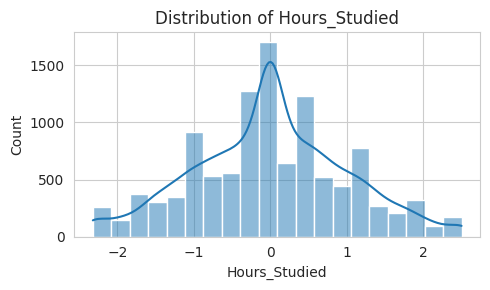

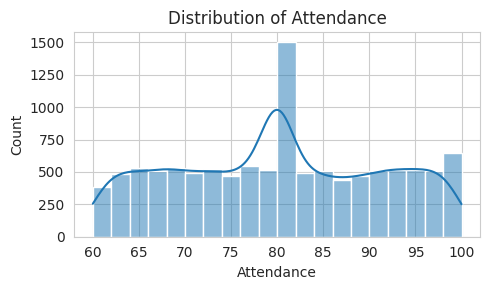

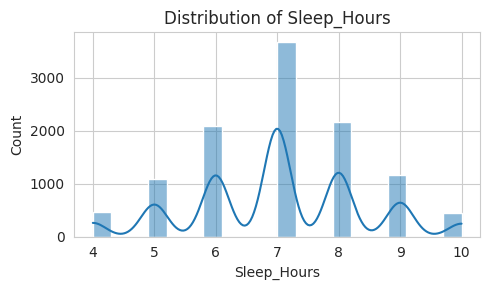

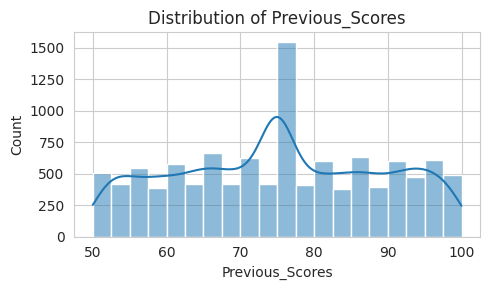

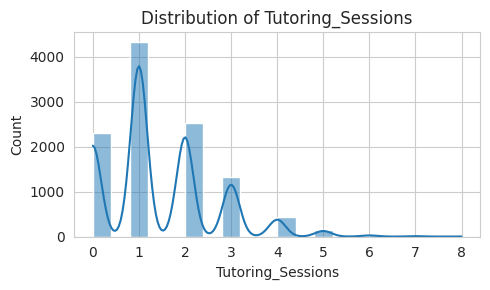

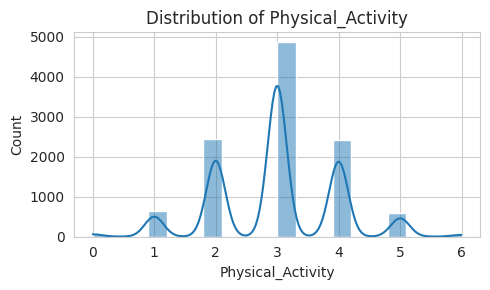

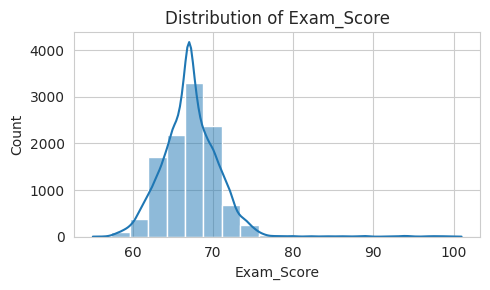

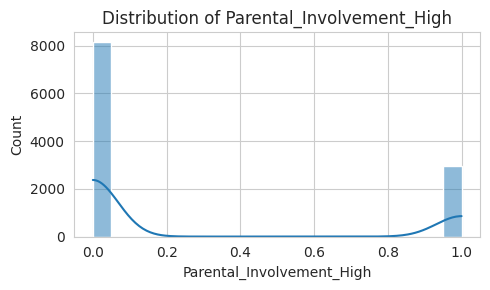

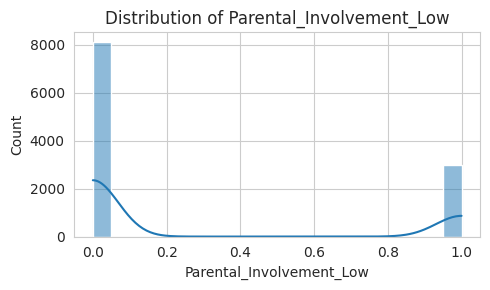

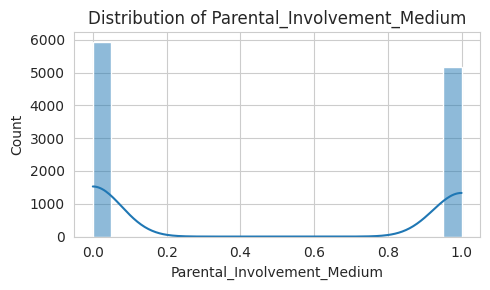

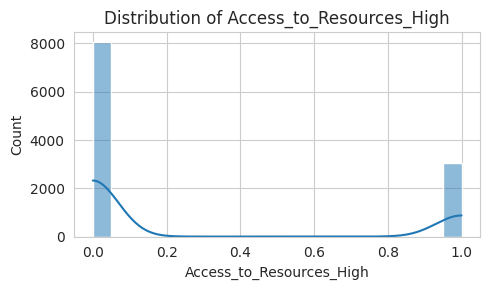

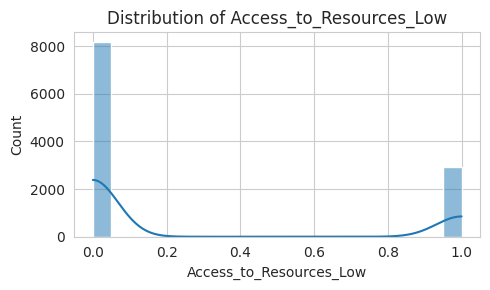

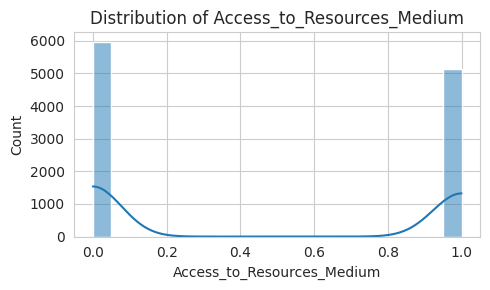

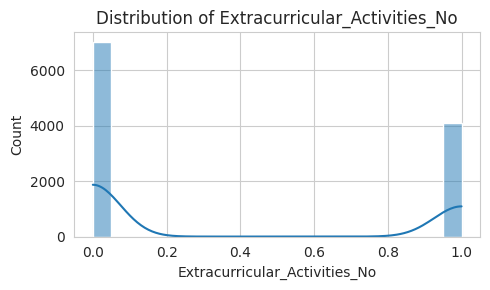

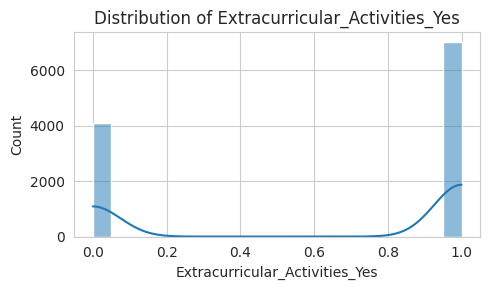

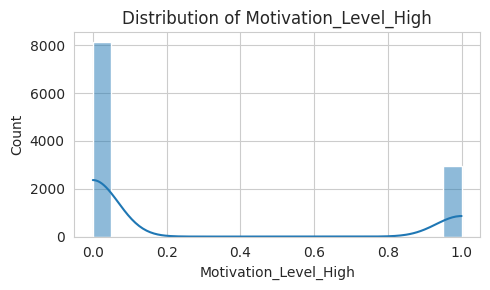

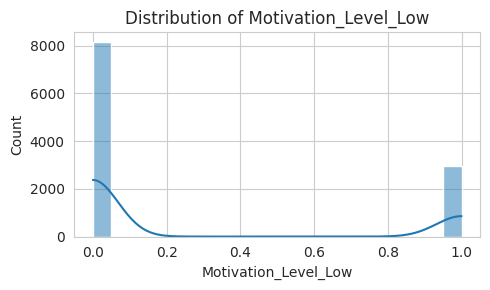

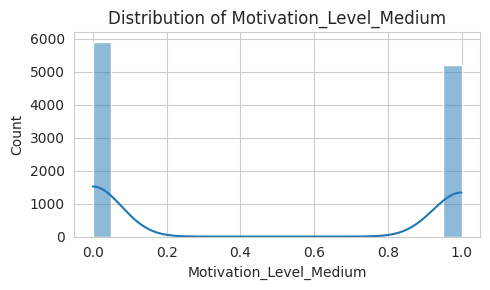

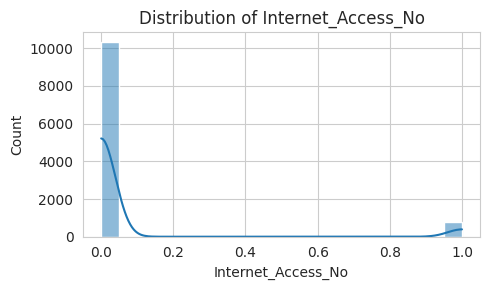

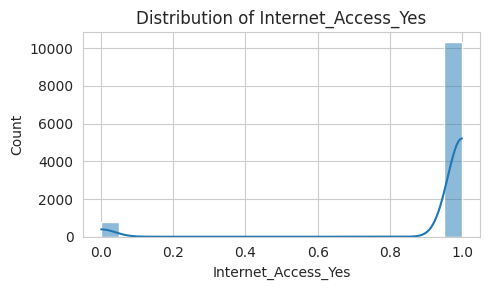

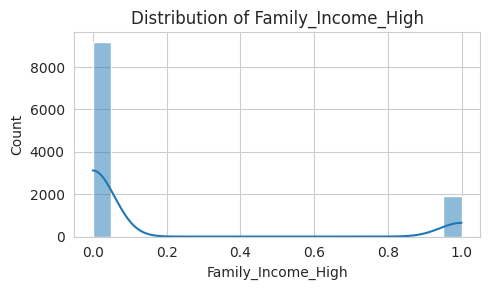

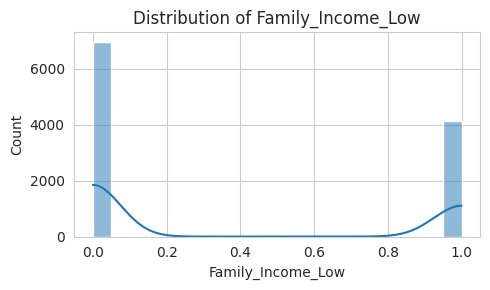

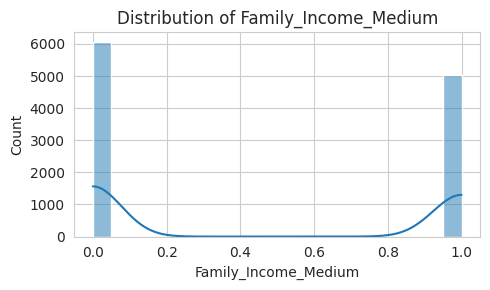

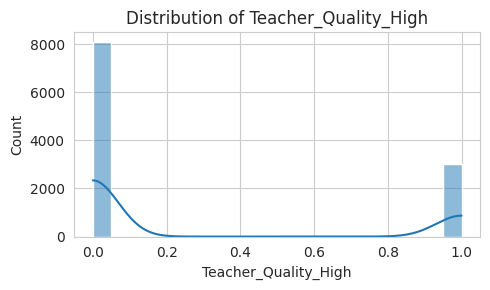

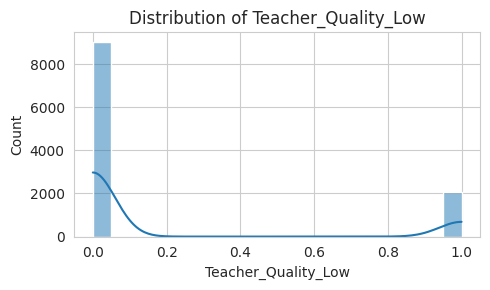

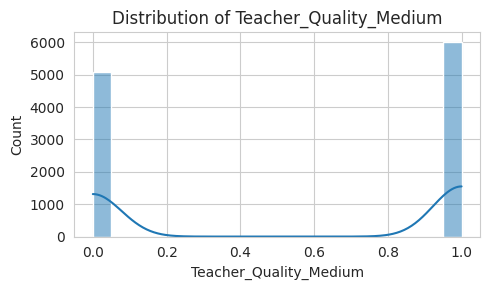

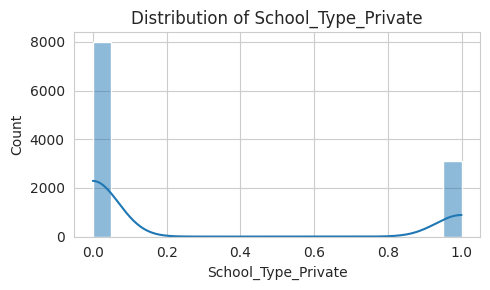

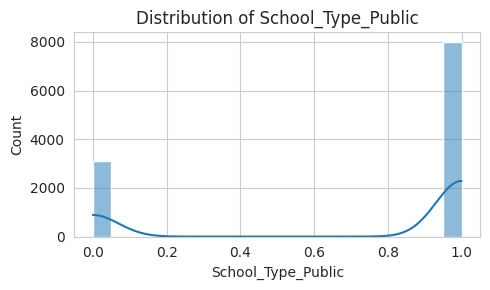

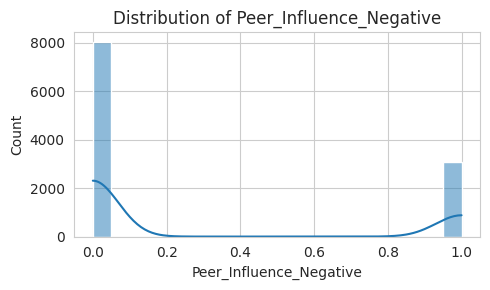

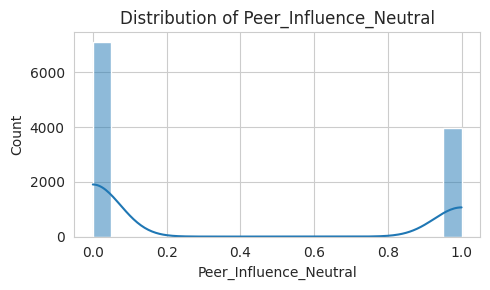

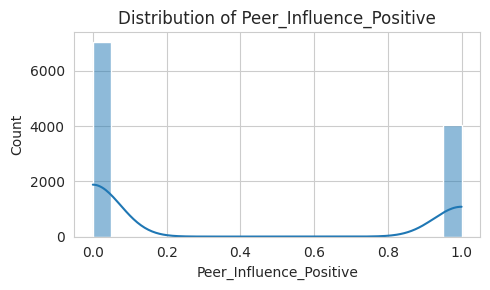

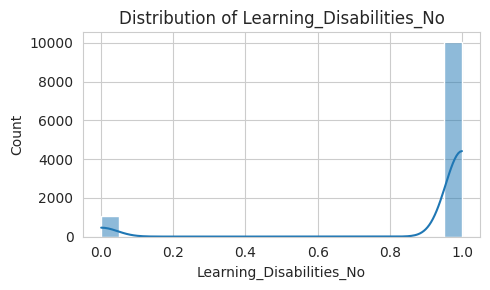

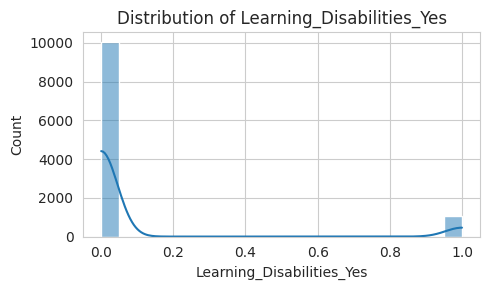

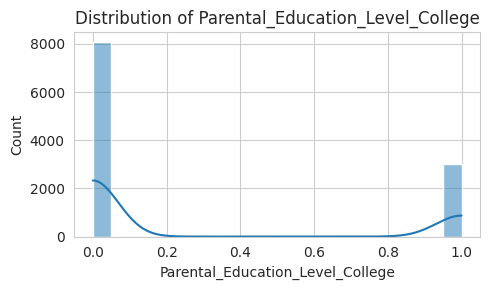

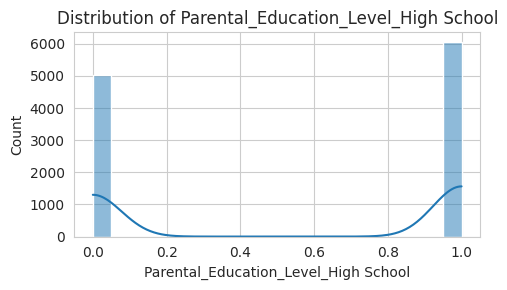

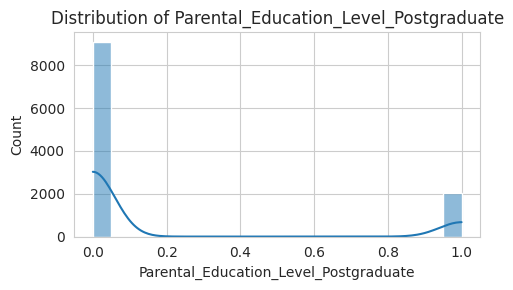

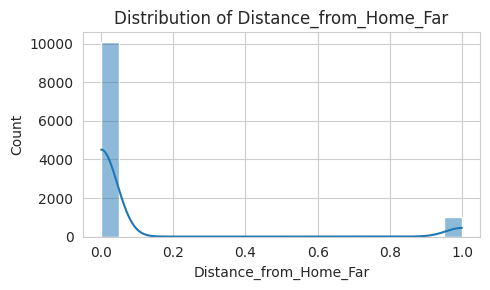

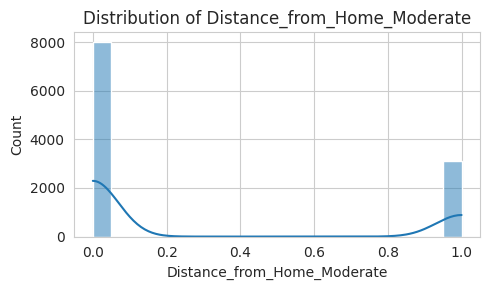

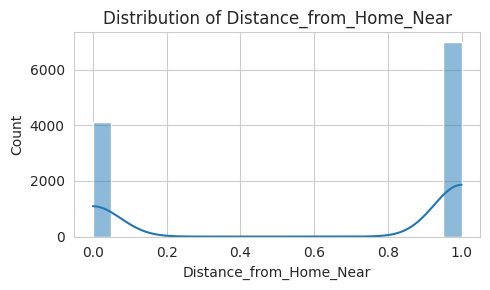

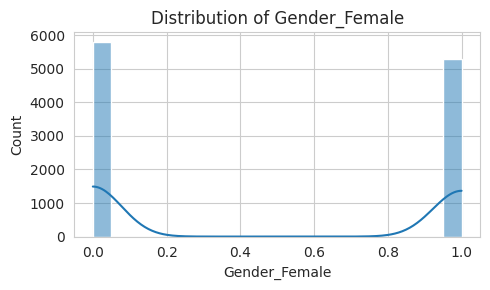

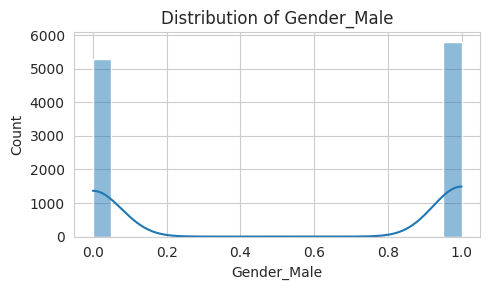

=== Countplots for Categorical Columns ===
=== Pairwise Scatter (Pairplot) ===


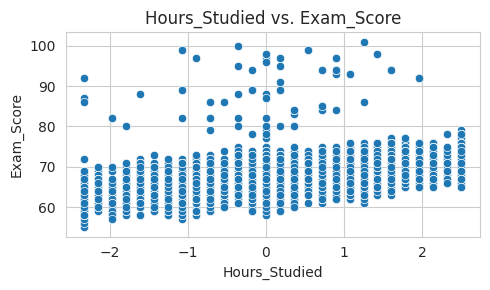

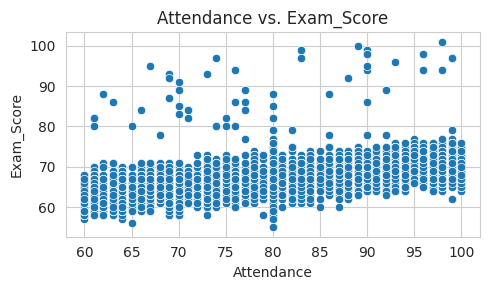

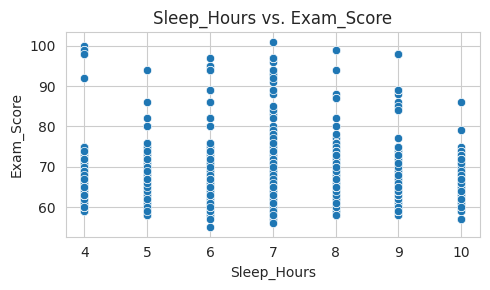

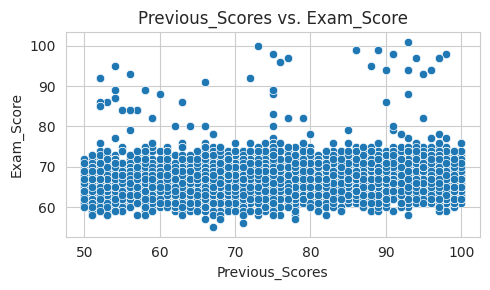

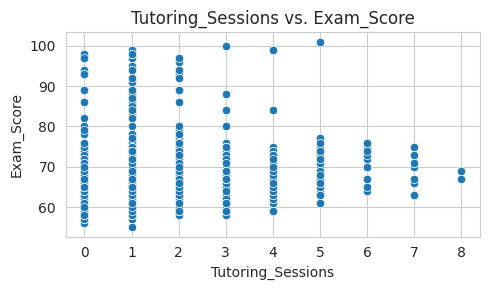

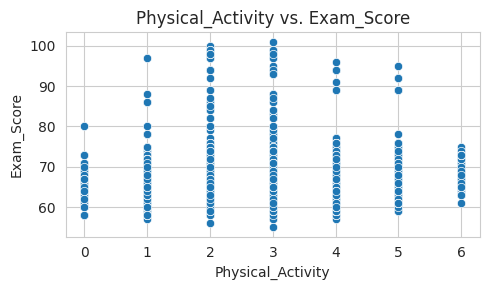

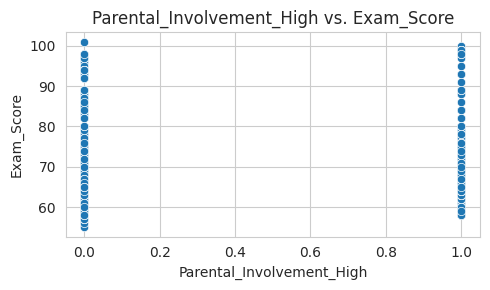

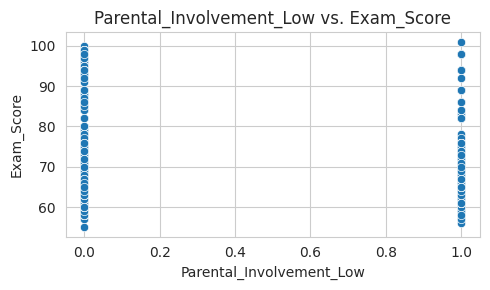

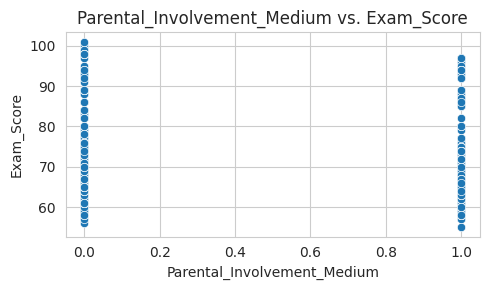

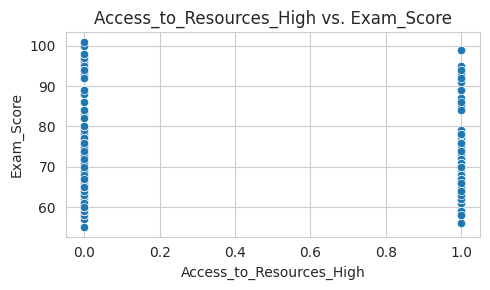

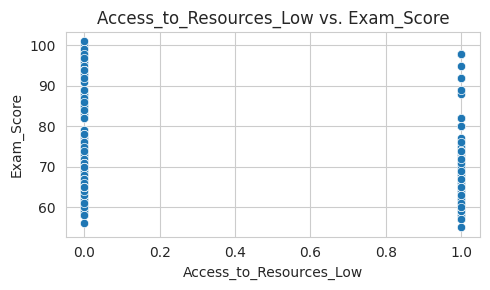

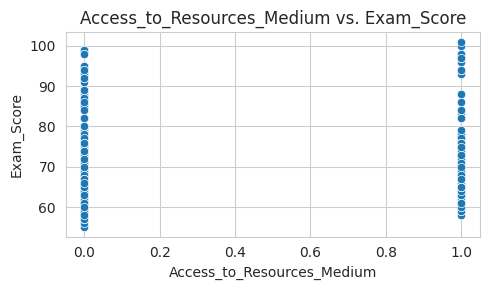

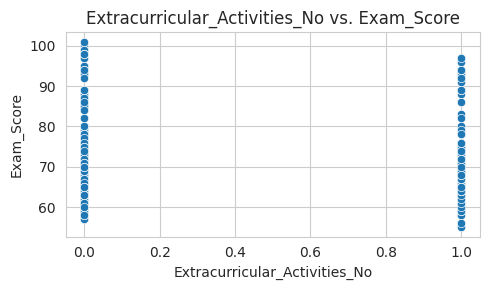

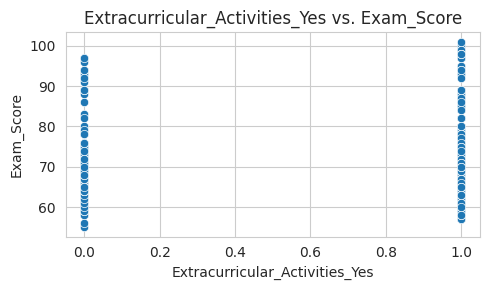

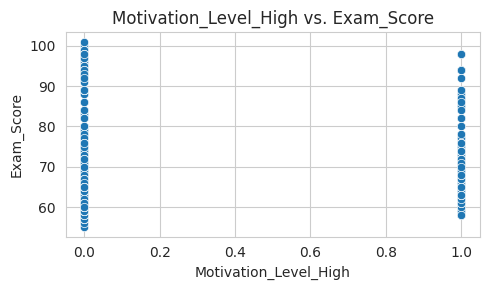

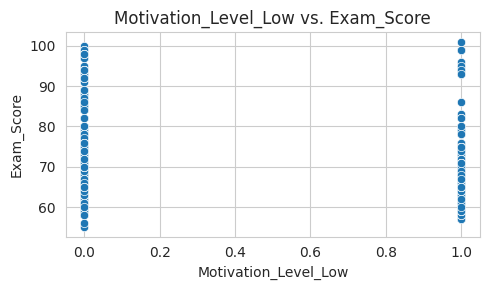

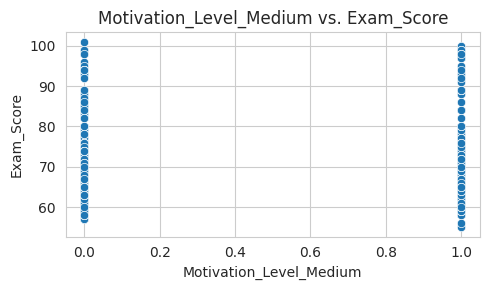

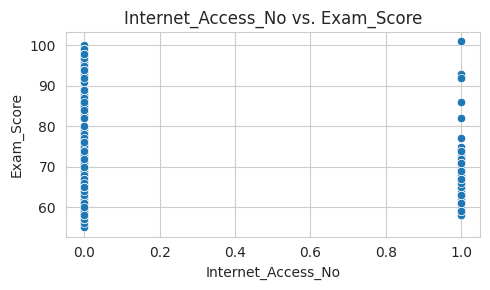

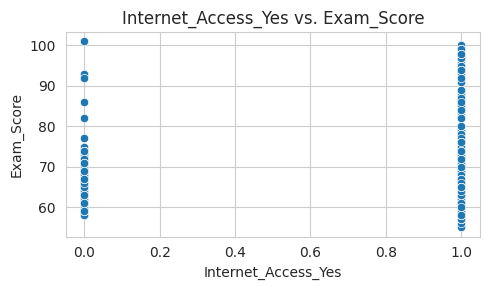

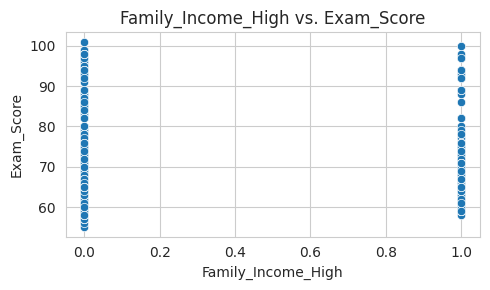

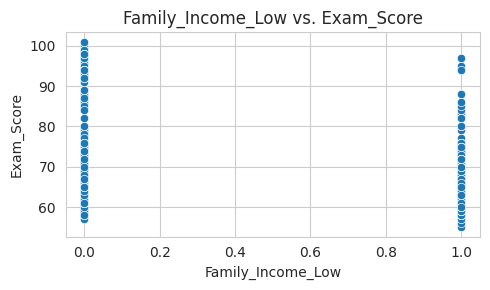

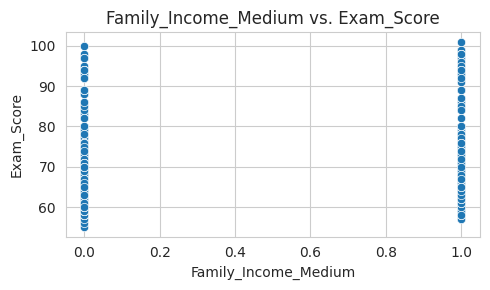

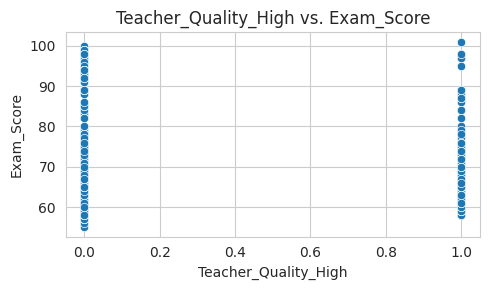

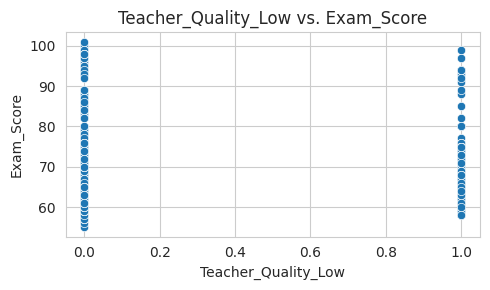

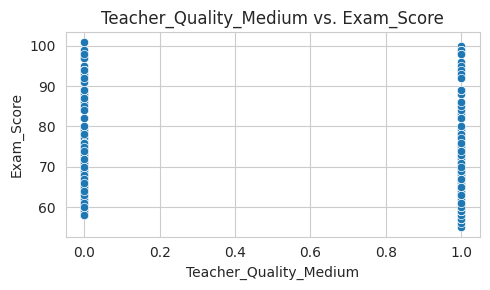

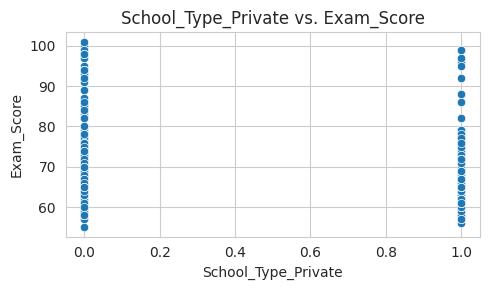

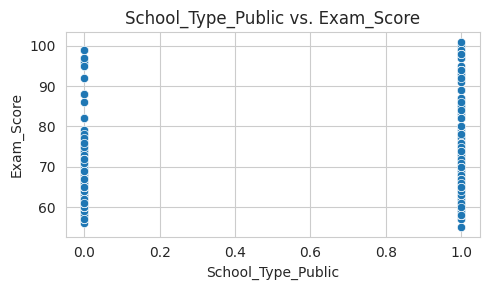

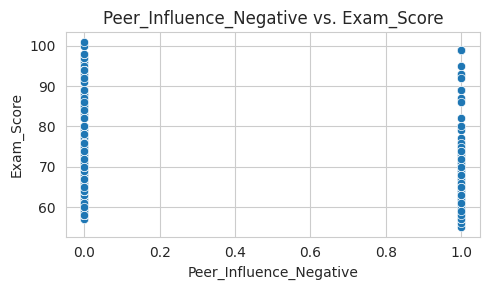

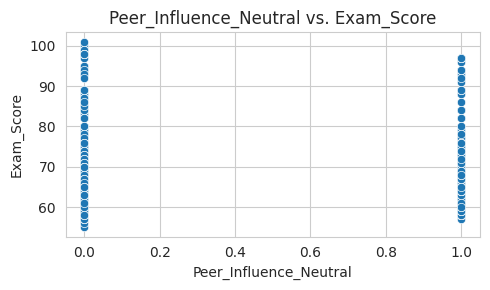

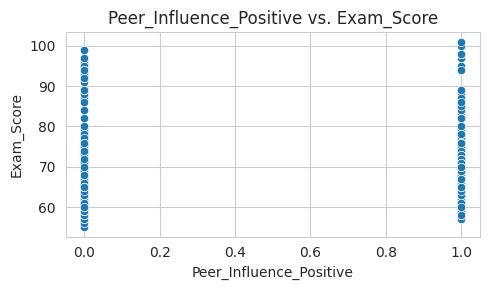

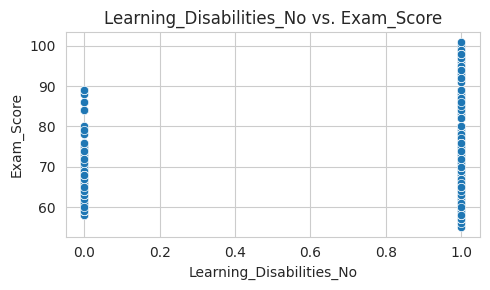

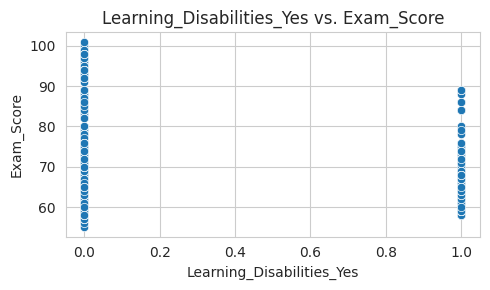

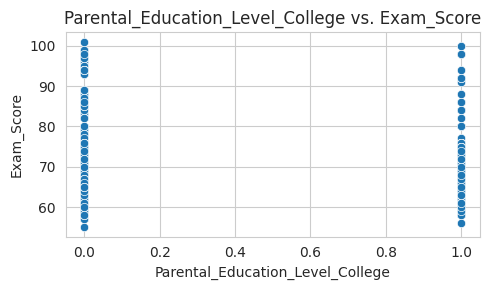

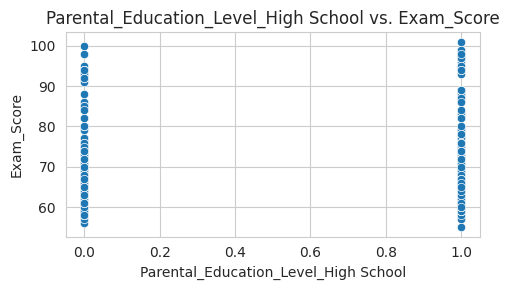

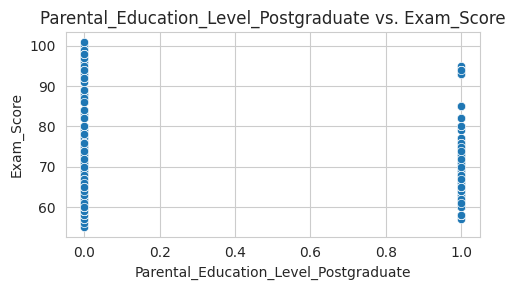

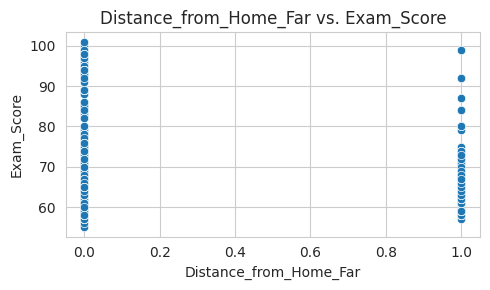

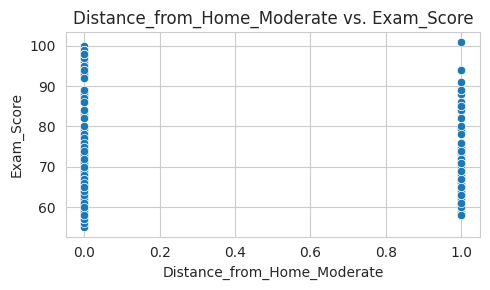

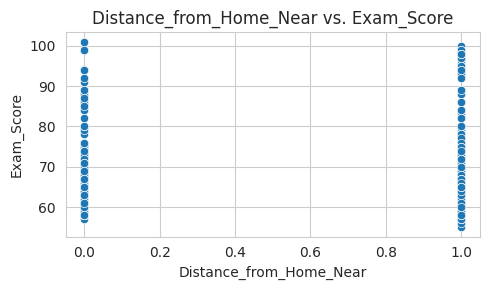

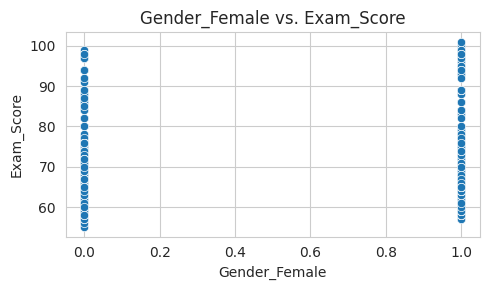

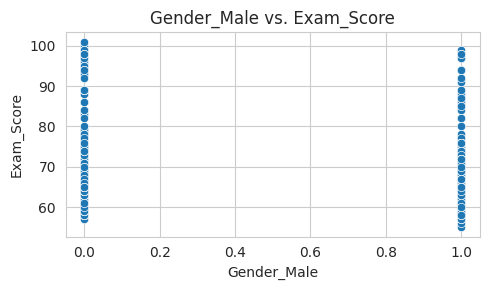

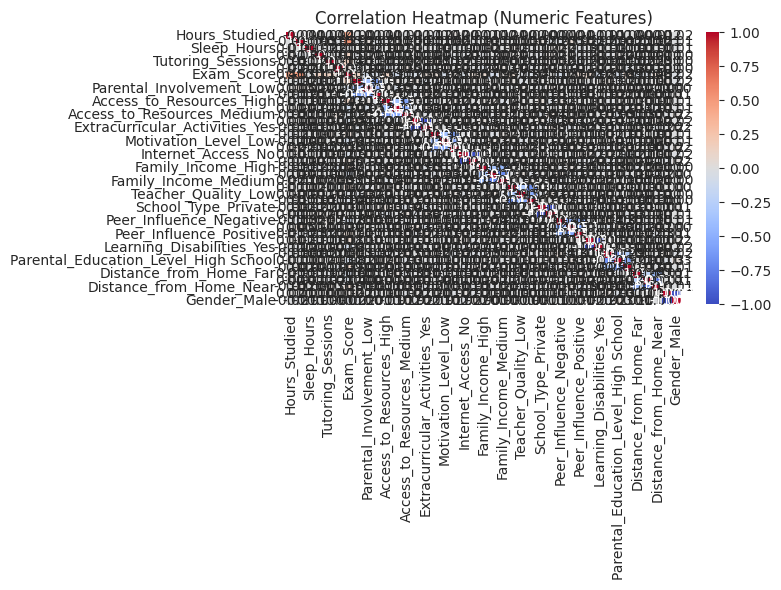

In [35]:
#####################################
# ADVANCED EDA SECTION
#####################################

import seaborn as sns
import matplotlib.pyplot as plt

# 1) UNIVARIATE ANALYSIS

# 1A) Histograms & KDE for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print("=== Histograms & KDE for Numeric Columns ===")
for col in numeric_cols:
    plt.figure(figsize=(5,3))
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

# 1B) Boxplots for numeric columns (quick outlier check)
# for col in numeric_cols:
#     plt.figure(figsize=(4,3))
#     sns.boxplot(x=df[col])
#     plt.title(f"Boxplot: {col}")
#     plt.tight_layout()
#     plt.show()

# 1C) Countplots for any remaining categorical columns
cat_cols = df.select_dtypes(include=[object]).columns.tolist()
print("=== Countplots for Categorical Columns ===")
for col in cat_cols:
    plt.figure(figsize=(5,3))
    sns.countplot(x=col, data=df)
    plt.title(f"Countplot: {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 2) BIVARIATE ANALYSIS

# 2A) Pairwise Scatter among numeric columns
print("=== Pairwise Scatter (Pairplot) ===")
if len(numeric_cols) <= 10:
    sns.pairplot(df[numeric_cols], corner=True, diag_kind='kde')
    plt.suptitle("Pairplot of Numeric Features", y=1.02)
    plt.show()

# 2B) If 'Exam_Score' is numeric, let's see correlation with each numeric col
if "Exam_Score" in df.columns:
    for col in numeric_cols:
        if col != "Exam_Score":
            plt.figure(figsize=(5,3))
            sns.scatterplot(x=df[col], y=df["Exam_Score"])
            plt.title(f"{col} vs. Exam_Score")
            plt.tight_layout()
            plt.show()

# 2C) Boxplots or Violin plots for each categorical vs. 'Exam_Score'
if "Exam_Score" in df.columns and cat_cols:
    for col in cat_cols:
        plt.figure(figsize=(5,3))
        sns.boxplot(x=col, y="Exam_Score", data=df)
        plt.title(f"{col} vs. Exam_Score")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# 3) MULTIVARIATE - CORRELATION HEATMAP
num_data = df.select_dtypes(include=[np.number])
if num_data.shape[1] > 1:
    plt.figure(figsize=(8,6))
    corr_matrix = num_data.corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.tight_layout()
    plt.show()


This section goes beyond basic histograms and countplots to provide a more thorough Exploratory Data Analysis (EDA). We focus on univariate analysis (histograms, countplots), bivariate analysis (pairwise scatterplots, scatter vs. Exam_Score, and boxplots vs. Exam_Score), and a multivariate correlation heatmap among numeric features. This helps uncover potential relationships, outliers, distribution shapes, and important correlations.

df.select_dtypes(include=[np.number]) retrieves a list of columns that are numeric (float64 or int64). We store these in numeric_cols.
For each numeric column col, we create a histogram with kde=True to overlay a Kernel Density Estimate curve, providing a smoothed view of the distribution.
bins=20 ensures we have a moderate bin count for clarity.
plt.tight_layout() helps avoid label overlap, and plt.show() displays the figure.
Why: Histograms and KDE plots let us see if a column is skewed (long tail), bimodal (two peaks), or fairly symmetric. This is crucial for deciding on transformations like log-scaling or outlier handling.

A boxplot is a quick way to visualize the median, interquartile range (IQR), and potential outliers for a numeric column.
If you uncomment this section, for each numeric column, it will show a horizontal boxplot.
Why: This helps identify extreme values that might need clipping or further investigation. If you encountered an error with certain columns, you can skip or fix them first (e.g., ensure the column is truly numeric).

df.select_dtypes(include=[object]) picks up columns that remain as strings (categorical data).
A countplot shows how many occurrences of each category exist in a given column (like “Low,” “Medium,” “High”).
Why: This reveals if one category dominates (class imbalance) or if the distribution is relatively balanced. For example, if “High” is extremely rare, that might be relevant for modeling or further analysis.

A pairplot (from Seaborn) creates a grid of scatterplots for every pair of numeric columns, plus diagonal histograms (or KDE plots) for each individual column.
We only run it if there are 10 or fewer numeric columns (if len(numeric_cols) <= 10) to avoid an overly cluttered matrix.
corner=True means we only show the lower triangle of the pairwise plots, reducing redundancy.
diag_kind='kde' uses a KDE curve on the diagonal instead of a histogram.
Why: This quickly reveals linear or non-linear relationships between any two numeric columns (e.g., Hours_Studied vs. Exam_Score) and can also show potential cluster patterns or outliers.

We specifically check if the column "Exam_Score" exists (the target variable).
For every numeric column other than "Exam_Score", we plot a scatterplot with that column on the x-axis and "Exam_Score" on the y-axis.
Why: This highlights potential correlations. A positive slope might mean higher Hours_Studied leads to higher Exam_Score. A random scatter might indicate no strong relationship. This is key for feature selection and understanding what influences the target variable.

If the dataset has a numeric Exam_Score and some remaining categorical columns (cat_cols), we create a boxplot for each category’s distribution of Exam_Score.
Why: This helps see if, for example, “High” Teacher_Quality yields a higher median exam score than “Low.” Or if “Yes” Extracurricular_Activities students have a different exam score distribution than “No.”
Rotation=45 for x-axis labels ensures categories remain readable if there are many or long category names.

num_data = df.select_dtypes(include=[np.number]) extracts only numeric columns from the DataFrame.
corr_matrix = num_data.corr() computes the Pearson correlation between every pair of numeric features.
sns.heatmap(...) visualizes these correlations in a grid, with annot=True to print the correlation coefficient and a color gradient (red for positive, blue for negative, etc.).
Why: This provides a high-level overview of which features are strongly or weakly correlated. For instance, if Previous_Scores is strongly correlated with Exam_Score, that’s an important insight for modeling.
We only do this if there is more than 1 numeric column (if num_data.shape[1] > 1).

Univariate: Histograms (and optional boxplots) let us see distribution shapes and potential outliers.
Bivariate: Pairplots, scatterplots vs. Exam_Score, and boxplots vs. Exam_Score reveal relationships between features and the target or between features themselves.
Multivariate: The correlation heatmap shows how all numeric columns interrelate, which is vital for feature selection or identifying collinearity.


Optimized R² Score: 0.6162777677122173
Optimized RMSE: 2.3996090112606323


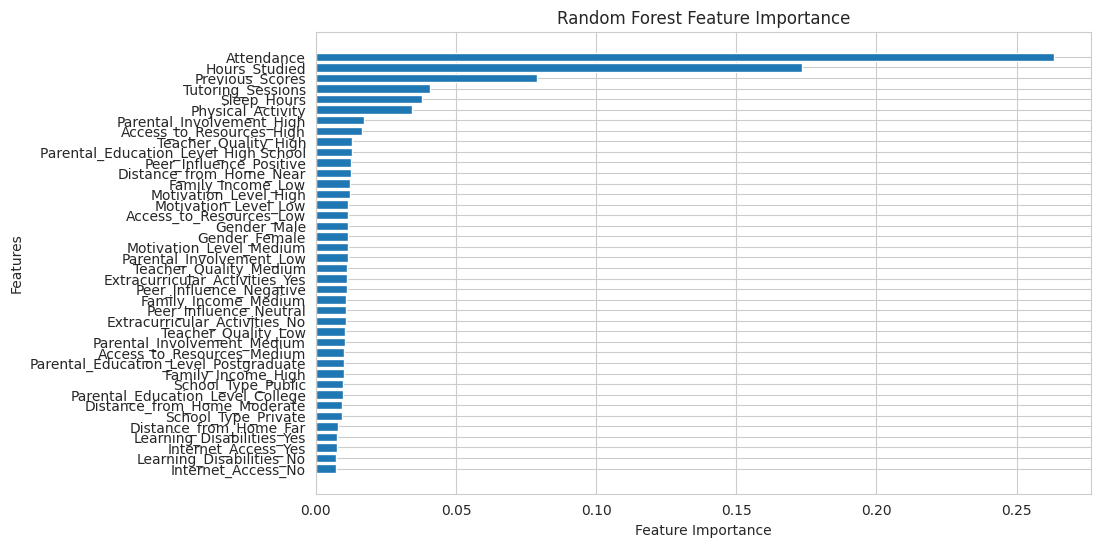


Feature Importance Rankings:
                                   Feature  Importance
1                              Attendance    0.263293
0                           Hours_Studied    0.173489
3                         Previous_Scores    0.079086
4                       Tutoring_Sessions    0.040787
2                             Sleep_Hours    0.037993
5                       Physical_Activity    0.034470
6               Parental_Involvement_High    0.017310
9                Access_to_Resources_High    0.016315
22                   Teacher_Quality_High    0.012839
33   Parental_Education_Level_High School    0.012823
29                Peer_Influence_Positive    0.012623
37                Distance_from_Home_Near    0.012620
20                      Family_Income_Low    0.012349
14                  Motivation_Level_High    0.012047
15                   Motivation_Level_Low    0.011649
10                Access_to_Resources_Low    0.011596
39                            Gender_Male    0.0115

In [36]:
############################################
# MACHINE LEARNING - PART 1: REGRESSION MODEL
############################################

# Import the necessary libraries for machine learning
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.ensemble import RandomForestRegressor    # Our main regression algorithm
from sklearn.metrics import mean_squared_error, r2_score  # For model evaluation
import numpy as np  # For numerical operations

# Step 1: Define target and feature variables
# --------------------------------------------
# We're using Exam_Score as our target variable (what we want to predict)
# All other numeric columns will be used as features (predictors)
y = df['Exam_Score']  # Target: The student's exam score
x = df.drop(['Exam_Score'], axis=1)  # Features: All other columns

# Step 2: Split the data into training and testing sets
# ----------------------------------------------------
# We use 80% of our data for training the model and reserve 20% for testing
# Setting random_state ensures reproducibility of results
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Step 3: Train the Random Forest Regression model
# -----------------------------------------------
# Random Forest is an ensemble learning method that builds multiple decision trees and
# combines their predictions for better accuracy and to prevent overfitting
best_rf = RandomForestRegressor(
    n_estimators=100,     # Number of trees in the forest
    max_depth=None,       # Maximum depth of the trees (None means unlimited)
    min_samples_split=2,  # Minimum samples required to split an internal node
    min_samples_leaf=1,   # Minimum samples required to be at a leaf node
    random_state=42       # Ensures reproducibility
)

# Fit the model to our training data
best_rf.fit(X_train, y_train)

# Step 4: Evaluate the model's performance
# ----------------------------------------
# Make predictions on our test set
y_pred = best_rf.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared, proportion of variance explained

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Step 5: Analyze feature importance
# ----------------------------------
# Random Forests provide a measure of how important each feature is for prediction
# We extract this information to identify which factors most strongly influence exam scores
feature_importance = best_rf.feature_importances_

# Sort features by importance (descending order)
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_features = [x.columns[i] for i in sorted_idx]
sorted_importance = feature_importance[sorted_idx]

# Visualize feature importance with a bar chart
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_importance)), sorted_importance)
plt.yticks(range(len(sorted_importance)), sorted_features)
plt.xlabel('Importance')
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

# Convert to DataFrame for better readability
importance_df = pd.DataFrame({
    'Feature': sorted_features,
    'Importance': sorted_importance
})
print(importance_df)

# Step 6: Feature Selection - Remove Less Important Features
# ---------------------------------------------------------
# Based on feature importance, we can simplify our model by keeping only
# the most influential features, which often leads to similar performance
# with a more interpretable model

# Set a threshold to remove features with very low importance (e.g., less than 0.01)
threshold = 0.01
important_features = [feature for feature, importance in
                     zip(sorted_features, sorted_importance) if importance >= threshold]
print(f"Selected {len(important_features)} important features")

# Reduce dataset to only important features
X_reduced = x[important_features]
X_train_reduced, X_test_reduced = train_test_split(X_reduced, test_size=0.2, random_state=42)

# Step 7: Retrain Model with Reduced Features
# -------------------------------------------
# Train a new Random Forest using only the important features
best_rf_reduced = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)
best_rf_reduced.fit(X_train_reduced, y_train)

# Step 8: Evaluate the simplified model
# -------------------------------------
# Test if feature selection maintained or improved performance
y_pred_reduced = best_rf_reduced.predict(X_test_reduced)
mse_reduced = mean_squared_error(y_test, y_pred_reduced)
rmse_reduced = np.sqrt(mse_reduced)
r2_reduced = r2_score(y_test, y_pred_reduced)

print(f"Reduced Model - Mean Squared Error: {mse_reduced:.2f}")
print(f"Reduced Model - Root Mean Squared Error: {rmse_reduced:.2f}")
print(f"Reduced Model - R² Score: {r2_reduced:.2f}")

# Compare the full and reduced models
print("\nComparison:")
print(f"Full model features: {x.shape[1]}, Reduced model features: {len(important_features)}")
print(f"Performance difference (R²): {r2 - r2_reduced:.4f}")

In [37]:
############################################
# MACHINE LEARNING - PART 2: CLASSIFICATION MODEL
############################################

# In this section, we'll convert the exam score prediction problem into a classification task
# where we predict grade categories (A, B, C, D, F) rather than exact scores

# Step 1: Discretize the continuous Exam_Score into grade categories
# -----------------------------------------------------------------
# Converting numerical scores into letter grade ranges allows us to treat this
# as a classification problem instead of regression

# Categorize the Exam_Score column into grade ranges
# Define bins (merging 50-54 into 55-59 and keeping 95-101 as the last range)
bins = [50, 59] + list(range(60, 95, 5)) + [101]  # Corrected last bin to match the range

# Define labels ensuring one less than bins
labels = ['F'] + [f"{chr(64 + (i//2))}{'-' if i % 2 else '+'}" for i in range(8, 0, -1)]

# Apply binning - this creates a new column with categorical grade ranges
df['Grade_Category'] = pd.cut(df['Exam_Score'], bins=bins, labels=labels, include_lowest=True)

# Convert range labels to float by taking the midpoint - useful for certain visualizations
df['Grade_Numeric'] = df['Grade_Category'].cat.codes

# Display how many values are in each range to check class balance
grade_counts = df['Grade_Category'].value_counts().sort_index()
print(grade_counts)

# Visualize the distribution of grades
plt.figure(figsize=(10, 6))
sns.countplot(x='Grade_Category', data=df, order=grade_counts.index)
plt.title('Distribution of Grades')
plt.xlabel('Grade Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Score_Range
70-74     6200
65-69     3019
75-79     1534
60-64      119
50-59      105
80-84       52
95-101      35
90-94       18
85-89       14
Name: count, dtype: int64



Evaluation Metrics:
Accuracy: 0.7757
Precision: 0.7947
Recall: 0.7757
F1 Score: 0.7599

Classification Report (Random Forest):
               precision    recall  f1-score   support

       50-59       1.00      0.35      0.51        26
       60-64       1.00      0.35      0.52        23
       65-69       0.81      0.65      0.72       613
       70-74       0.75      0.94      0.84      1228
       75-79       0.90      0.47      0.61       300
       80-84       1.00      0.17      0.29        12
       85-89       0.00      0.00      0.00         4
       90-94       0.00      0.00      0.00         7
      95-101       1.00      0.57      0.73         7

    accuracy                           0.78      2220
   macro avg       0.72      0.39      0.47      2220
weighted avg       0.79      0.78      0.76      2220



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


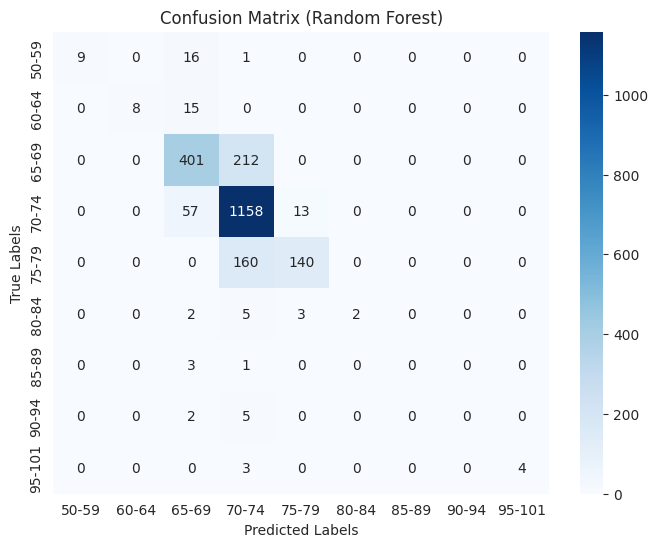

In [38]:
# Step 2: Prepare data for classification
# --------------------------------------
# Import necessary libraries for classification tasks
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Convert target to categorical
y = df['Grade_Category']  # Target is now the grade category
X = df.drop(['Exam_Score', 'Grade_Category', 'Grade_Numeric'], axis=1)  # Features

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train Random Forest Classifier
# -------------------------------------
# Random Forest works well for classification tasks and can handle categorical targets
rf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)

# Step 4: Make predictions and evaluate the classifier
# --------------------------------------------------
# Generate predictions on the test set
y_pred_rf = rf.predict(X_test)

# Calculate basic accuracy
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy:.4f}")

# Step 5: Detailed performance evaluation
# --------------------------------------
# Evaluate with more detailed metrics beyond simple accuracy

# Classification Report provides precision, recall, and F1-score for each class
print("\nClassification Report (Random Forest):\n", classification_report(y_test, y_pred_rf))

# Generate Confusion Matrix to see which classes are confused with each other
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Create a heatmap for better visualization of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=grade_counts.index,
            yticklabels=grade_counts.index)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest)')
plt.tight_layout()
plt.show()


In [39]:
############################################
# MACHINE LEARNING - PART 3: SIMPLIFIED CLASSIFICATION MODEL
############################################

# In this section, we reduce the number of grade categories to improve
# classification performance by addressing class imbalance issues

# Step 1: Redefine grade categories with broader bins
# --------------------------------------------------
# Use broader grade ranges (10 point intervals) to have fewer, more balanced classes

# Define new bins for ranges of 10
bins = [50, 60, 70, 80, 90, 101]  # Bin edges
labels = ["50-59", "60-69", "70-79", "80-89", "90-101"]  # Corresponding labels

# Apply binning
df['Grade_Category'] = pd.cut(df['Exam_Score'], bins=bins, labels=labels, include_lowest=True)

# Convert range labels to float by taking the midpoint
df['Grade_Numeric'] = df['Grade_Category'].cat.codes

# Display counts for each category
grade_counts = df['Grade_Category'].value_counts().sort_index()
print(grade_counts)

# Visualize the new grade distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Grade_Category', data=df, order=grade_counts.index)
plt.title('Distribution of Simplified Grades')
plt.xlabel('Grade Range')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Score_Range
60-69     9219
70-79     1586
50-59      224
90-101      35
80-89       32
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Evaluation Metrics (Random Forest):
Accuracy: 0.9072
Precision: 0.9055
Recall: 0.9072
F1 Score: 0.8929

Classification Report (Random Forest):
               precision    recall  f1-score   support

       50-59       1.00      0.27      0.42        49
       60-69       0.90      0.99      0.95      1841
       70-79       0.92      0.55      0.69       312
       80-89       0.00      0.00      0.00        11
      90-101       1.00      0.43      0.60         7

    accuracy                           0.91      2220
   macro avg       0.77      0.45      0.53      2220
weighted avg       0.91      0.91      0.89      2220



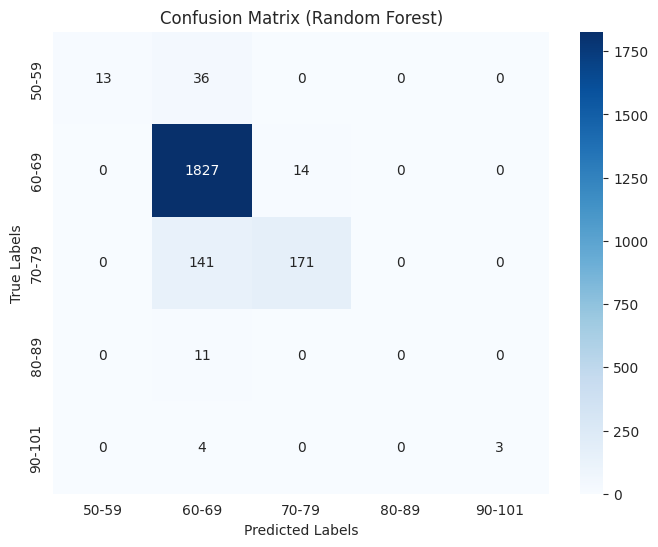

In [40]:
from sklearn.ensemble import RandomForestClassifier

# Step 2: Prepare data for classification with new categories
# ---------------------------------------------------------
# Similar process as before but with our new simplified grade ranges

# Convert target to categorical
y = df['Grade_Category']  # Target is the simplified grade range
X = df.drop(['Exam_Score', 'Grade_Category', 'Grade_Numeric'], axis=1)  # Features

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train Random Forest Classifier
# -------------------------------------
# Using fewer estimators since we have simpler categories
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 4: Make predictions with the classifier
# -------------------------------------------
y_pred_rf = rf.predict(X_test)

# Step 5: Evaluate the simplified classifier
# -----------------------------------------
# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy:.4f}")

print("\nEvaluation Metrics (Random Forest):")
print(f"Accuracy: {accuracy:.4f}")

# Classification Report for detailed metrics per class
print("\nClassification Report (Random Forest):\n", classification_report(y_test, y_pred_rf))

# Generate and visualize confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Create a heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=grade_counts.index,
            yticklabels=grade_counts.index)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest)')
plt.tight_layout()
plt.show()

# Step 6: Analyze feature importance for grade prediction
# -----------------------------------------------------
# Identify which factors most strongly influence grade categories
importance = rf.feature_importances_
sorted_idx = np.argsort(importance)[::-1]
sorted_features = [X.columns[i] for i in sorted_idx]
sorted_importance = importance[sorted_idx]

# Display feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_importance[:15])), sorted_importance[:15])
plt.yticks(range(len(sorted_importance[:15])), [sorted_features[i] for i in range(15)])
plt.xlabel('Importance')
plt.title("Top 15 Features for Grade Prediction")
plt.tight_layout()
plt.show()